# EventBasedBacktester - A interface for strategy class that takes in a dataframe, and then trades on the data.

1. Data Collection
2. Trade Execution
   1. Transaction costs
   2. Manages position and quantity tracking for multiple securities
   3. Handles basic buy/sell order execution
   4. Records trade details including timestamp, price, quantity
3. Risk Management
   1. Tracks realized account balance
   2. Monitors unrealized positions
   3. Set maximum position size
   4. Stops account if value falls below 0.
4. Performance Analysis
   1. Calculates various performance metrics (Sharpe ratio, drawdown, etc.)
   2. Provides visualization of performance through multiple plots
   3. Tracks trade history and portfolio evolution

In [173]:
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from typing import Optional, Union, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

class OrderType(Enum):
    MARKET = "MARKET"
    # LIMIT = "LIMIT"
    # STOP = "STOP"

# A trade is an order that has been executed. Assume that all trades were executed immediately.
@dataclass
class Trade:
    timestamp : int
    datetime : datetime
    position: int
    type: OrderType
    quantity: float
    price: float
    transaction_cost: float

@dataclass
class StrategyPerformance:
    symbol: str
    timestamp : int
    datetime : datetime
    position : int
    quantity: float
    price: float
    transaction_cost: float
    intial_capital : float
    realized_balance: float
    unrealized_balance: float
    total_balance: float
@dataclass
class ReturnsPerformance:
    symbol: str
    timestamp : int
    datetime: datetime
    position: int
    price: float
    total_balance : float

    # Calculated in performance
    # capital_regular_returns: float
    # capital_log_returns: float
    # capital_returns_logcumsum: float

class EventBasedBacktester:
    """
    Event based backtest for generic trading strategy.
    """
    def __init__(self, symbol, start, end, interval, transaction_fee, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.data = self.prepare_data()
        if self.data.empty:
            raise ValueError(f"DATA IS EMPTY FOR {symbol}")

        """
        Trade settings
        """
        self.transaction_fee = transaction_fee
        self.initial_capital = None

        """
        Performance values.
        """
        self.current_position = 0
        self.current_capital = None
        self.transaction_costs = 0
        self.trades: List[Trade] = []
        self.strategy_performance: List[StrategyPerformance] = []
        self.returns_performance: List[ReturnsPerformance] = []

        """
        Miscellanous
        """
        self.minimum_balance = None
        self.stop_trading = False
        self.verbose = verbose

        self.has_run = False

    def set_capital(self, capital):
        """
        Set the capital for the strategy. This should be called before running the strategy.
        """
        self.initial_capital = capital
        self.current_capital = capital
        self.minimum_balance = capital * 0.1
        if self.verbose == True:
            print(f"Initial Capital set to {capital}")

    def prepare_data(self):
        """
        Ensure data is in correct format with proper column names
        """
        stock_data = yf.Ticker(self.symbol)
        data = stock_data.history(start=self.start, end=self.end, interval=self.interval
                                #   , auto_adjust=False
                                  ).reset_index().rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume',
            'Date': 'datetime'
        })
        data['timestamp'] = data['datetime'].apply(lambda x: int(x.timestamp() * 1000))
        data = data.sort_values('timestamp', ascending=True).reset_index(drop=True)
        data['logreturns_close'] = np.log(data['close'] / data['close'].shift(1))
        data['returns_close'] = (data['close'] / data['close'].shift(1)) - 1
        return data
    """
    Strategy Function - to override strategy() method.
    """
    def strategy(self, row):
        # Should use the execute_order() method to execute trades.
        raise NotImplementedError("Implement the strategy method")

    def run_strategy(self):
        # print("in run_strategy")
        if self.has_run:
            # print("has run!!!!!!!!!!!")
            return
        self.has_run = True
        
        if self.initial_capital is None:
            self.set_capital(10000)
            print("INITIAL CAPITAL NOT SET. SETTING TO DEFAULT $10,000")
        for i, r in self.data.iterrows():
            # Check balance
            self.check_balance(timestamp=r['timestamp'])
            if self.stop_trading == False:
                # Execute Startegy
                self.strategy(row = r)
                # Closes strategy on the last timestamp
                if i == len(self.data) - 1 and self.current_position != 0:
                    self.close_current_position(timestamp=self.data.iloc[-1]['timestamp'])
            # Add return on each iteration.
            # Adds returns on the last trade, which will include transaction costs because of total balance.
            self.returns_performance.append(
                ReturnsPerformance(
                    symbol=self.symbol,
                    timestamp=r['timestamp'],
                    datetime=pd.to_datetime(r['timestamp'], unit='ms'),
                    position=self.current_position,
                    price=r['close'],
                    total_balance=self.total_balance(timestamp=r['timestamp'])
                )
            )
    """
    Getters
    """
    def get_current_position(self):
        return self.current_position
    def get_timestamp_price(self, timestamp):
        return self.data[self.data['timestamp'] == timestamp].iloc[0]

    def realized_balance(self):
        return self.current_capital

    def unrealized_balance(self, timestamp):
        return self.current_position * self.get_timestamp_price(timestamp)['close']

    def total_balance(self, timestamp):
        return self.realized_balance() + self.unrealized_balance(timestamp)

    def get_most_recent_trade(self):
        return self.trades[-1]
    """
    Trade
    """
    def add_portfolio_performance(self, timestamp, position, quantity, price, transaction_cost, initial_capital):
        portfolio_performance = StrategyPerformance(
            symbol=self.symbol,
            timestamp=timestamp,
            datetime=pd.to_datetime(timestamp, unit='ms'),
            position=position,
            quantity=quantity,
            price=price,
            transaction_cost=transaction_cost,
            intial_capital=initial_capital,
            realized_balance=self.realized_balance(),
            unrealized_balance=self.unrealized_balance(timestamp),
            total_balance=self.total_balance(timestamp)
        )
        self.strategy_performance.append(portfolio_performance)
        if self.verbose == True:
            print(
                f"ReturnsPerformance - Timestamp : {timestamp} / Datetime {pd.to_datetime(timestamp, unit='ms').strftime('%d/%m/%Y, %H:%M:%S')}, "
                f"Position : {'LONG' if position == 1 else 'SHORT'}, "
                f"Quantity : {quantity}, Current Price : {price}, "
                f"Transaction Cost : {transaction_cost}, "
                f"Initial Capital : {initial_capital}, "
                f"Realized Balance : {self.realized_balance()}, "
                f"Unrealized Balance : {self.unrealized_balance(timestamp=timestamp)}, "
                f"Total Balance : {self.total_balance(timestamp=timestamp)}"
            )

    def add_trade(self, timestamp, position, type, quantity, price, transaction_cost):
        trade = Trade(timestamp=timestamp,
                    datetime=pd.to_datetime(timestamp, unit='ms'),
                    position=position,
                    type=type,
                    quantity=quantity,
                    price=price,
                    transaction_cost=transaction_cost)
        self.trades.append(trade)
        if self.verbose == True:
            print(
                f"StrategyPerformance - Timestamp : {timestamp} / Datetime {pd.to_datetime(timestamp, unit='ms').strftime('%d/%m/%Y, %H:%M:%S')}, "
                f"Position : {'LONG' if position == 1 else 'SHORT'}, "
                f"Quantity : {quantity}, Price : {price}"
            )

    def execute_order(self, timestamp, position: int, quantity : int = None, type : OrderType = OrderType.MARKET):
        if position not in [-1, 1]:
            raise ValueError("Position must be either 1 (long) or -1 (short)")
        initial_capital = self.total_balance(timestamp=timestamp)
        # We assume that trades can be excuted at close, even though this might be unrealistic. Alternatively we use Open-to-Open to calculate the results.
        current_price = self.get_timestamp_price(timestamp)['close']
        # Calculate positions depending on amount.
        transaction_cost = (current_price * quantity) * self.transaction_fee
        quantity_cost = current_price * quantity
        total_cost = quantity_cost + transaction_cost
        if position == 1:
            # if total_cost > self.current_capital:
            #     # raise ValueError("Insufficient capital for long position")
            #     print("Insufficient capital for long position")
            #     return
            self.current_capital = self.current_capital - total_cost
            self.current_position += quantity
            self.transaction_costs += transaction_cost
        elif position == -1:
            # # Check if resulting position would exceed minimum balance requirement
            # if (self.current_capital + (current_price * quantity) - transaction_cost) < self.minimum_balance:
            #     # raise ValueError("Short position would exceed minimum balance requirement")
            #     print("Short position would exceed minimum balance requirement")
            #     return
            # Capital added for a short position - in this case we are borrowing, but you have to check in get_total_balance to ensure that the trade does not go past minimum balance.
            self.current_capital = self.current_capital + quantity_cost - transaction_cost
            self.current_position -= quantity
            self.transaction_costs += transaction_cost
        else:
            raise ValueError("Position must be either 1 or -1")
        self.add_trade(
            timestamp=timestamp,
            position=position,
            type=type,
            quantity=quantity,
            price=current_price,
            transaction_cost=transaction_cost,
        )
        self.add_portfolio_performance(
            timestamp=timestamp,
            position=position,
            quantity=quantity,
            price=current_price,
            transaction_cost=transaction_cost,
            initial_capital = initial_capital,
        )
    def long_all(self, timestamp):
        """
        Enter a long position with all available capital.

        Args:
            timestamp: The timestamp of the order
        """
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.realized_balance() / (current_price * (1 + self.transaction_fee)))

        if max_quantity <= 0:
            if self.verbose == True:
                print("EXECUTION ERROR: NOT ENOUGH CAPITAL FOR A LONG POSITION.")
            return

        self.execute_order(
            timestamp=timestamp,
            position=1,
            quantity=max_quantity
        )

    def short_all(self, timestamp):
        """
        Enter a short position with all available capital.

        Args:
            timestamp: The timestamp of the order
        """
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.realized_balance() / (current_price * (1 + self.transaction_fee)))

        if max_quantity <= 0:
            if self.verbose == True:
                print("EXECUTION ERROR: NOT ENOUGH CAPITAL FOR A SHORT POSITION.")
            return

        self.execute_order(
            timestamp=timestamp,
            position=-1,
            quantity=max_quantity
        )

    def close_current_position(self, timestamp):
        """
        Close the current position completely at the current market price.

        Args:
            timestamp: The timestamp of the order
        """
        # print(f"Attempting to close current position at {timestamp} / {pd.to_datetime(timestamp, unit='ms').strftime("%d/%m/%Y, %H:%M:%S")}")
        if self.current_position == 0:
            print("ERROR CALLING close_current_position: No position to close")
            return

        # If current_position is positive, we need to sell (short)
        # If current_position is negative, we need to buy (long)
        closing_position = -1 if self.current_position > 0 else 1

        self.execute_order(
            timestamp=timestamp,
            position=closing_position,
            quantity=self.current_position if self.current_position > 0 else -self.current_position
        )

    def check_balance(self, timestamp):
        total_balance = self.total_balance(timestamp=timestamp)

        if total_balance < self.minimum_balance and self.stop_trading == False:
            try:
                self.close_current_position(timestamp)
                self.stop_trading = True
                if self.verbose:
                    print(f"MINIMUM VALUE BREACHED: Stopping trading. Final balance: {total_balance}")
            except Exception as e:
                raise ValueError(f"Failed to close positions on minimum balance breach: {str(e)}")
                # if self.verbose:
                #     print(f"ERROR CHECKING BALANCE: Failed to close positions on minimum balance breach: {str(e)}")
    def get_performance(self):
        """
        Calculate performance metrics based on balance returns and log returns
        """
        # Convert strategy performance to DataFrame
        df = pd.DataFrame(self.returns_performance)

        # Calculate returns
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['balance_logreturns'] = np.log(df['total_balance'] / df['total_balance'].shift(1))
        df['balance_logreturns_cumsum'] = df['balance_logreturns'].cumsum()

        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100

        # Time period calculations
        trading_days = len(df)
        annual_factor = 252  # Trading days in a year
        years = trading_days / annual_factor

        # 1. Total capital at end
        final_capital = df['total_balance'].iloc[-1]

        # 2. Annual regular returns
        total_return = (final_capital / self.initial_capital) - 1
        annual_return = ((1 + total_return) ** (1/years) - 1) * 100

        # 3. Annual regular std deviation
        daily_std = df['balance_returns'].std()
        annual_std = daily_std * np.sqrt(annual_factor) * 100

        # 4. Annual Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        excess_return = annual_return/100 - risk_free_rate
        sharpe_ratio = excess_return / (annual_std/100)

        # 5. Returns on investment for period
        total_return_pct = total_return * 100

        # 6. Maximum drawdown
        max_drawdown = abs(df['drawdown'].min())

        # 7. Maximum drawdown period
        # Calculate drawdown periods
        drawdown_periods = []
        current_drawdown = 0
        in_drawdown = False

        for dd in df['drawdown']:
            if dd < 0:  # In drawdown
                if not in_drawdown:
                    in_drawdown = True
                current_drawdown += 1
            else:  # Not in drawdown
                if in_drawdown:
                    drawdown_periods.append(current_drawdown)
                    current_drawdown = 0
                    in_drawdown = False

        if current_drawdown > 0:  # If still in drawdown at the end
            drawdown_periods.append(current_drawdown)

        max_drawdown_period = max(drawdown_periods) if drawdown_periods else 0

        # 8. Sortino Ratio
        negative_returns = df['balance_returns'][df['balance_returns'] < 0]
        downside_std = np.sqrt(annual_factor) * np.sqrt(np.mean(negative_returns**2))
        sortino_ratio = (annual_return/100 - risk_free_rate) / downside_std if downside_std != 0 else 0

        # 9. Total trades
        total_trades = len(self.trades)

        return {
            'total_capital': final_capital,
            'total_return': total_return_pct,
            'annual_returns': annual_return,
            'annual_std': annual_std,
            'max_drawdown': max_drawdown,
            'max_drawdown_period': max_drawdown_period,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'daily_std': daily_std * 100,
            'avg_daily_return': df['balance_returns'].mean() * 100,
            'total_trades': total_trades,
        }
    def print_performance_summary(self, metrics=None):
        """
        Print formatted performance metrics with border styling
        """
        if metrics is None:
            metrics = self.get_performance()

        border = "=" * 50
        print(f"\n{border}")
        print("Performance Metrics")
        print(f"The total capital at end of strategy: ${metrics['total_capital']:,.2f}")
        print(f"The annual regular returns: {metrics['annual_returns']:.2f} %")
        print(f"The annual regular std deviation: {metrics['annual_std']:.2f} %")
        print(f"The annual Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"The returns on investment from {self.start} to {self.end} by this strategy is {metrics['total_return']:.2f} %")
        print(f"The maximum drawdown: {metrics['max_drawdown']:.2f} %")
        print(f"The maximum drawdown period: {metrics['max_drawdown_period']:.2f} days")
        print(f"The annual Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"The total trades taken by the strategy: {metrics['total_trades']}")
        print(f"{border}")
    def plot_strategy_performance(self):
        """
        Create comprehensive strategy performance visualization with 6 subplots
        """
        # Get performance metrics
        metrics = self.get_performance()

        # Convert strategy performance to DataFrame
        df = pd.DataFrame([vars(p) for p in self.returns_performance])
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['cum_returns'] = (1 + df['balance_returns']).cumprod()
        df['log_cum_returns'] = np.log(df['cum_returns'])

        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100

        # Create figure with subplots
        fig = plt.figure(figsize=(30, 20))
        gs = fig.add_gridspec(3, 2, hspace=0.3)

        # 1. Cumulative Log Returns (Top Left)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(df['datetime'], df['log_cum_returns'], color='blue', linewidth=1.5)
        ax1.set_title('Cumulative Log Returns')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Log Returns')
        ax1.grid(True)

        # 2. Returns Distribution (Top Right)
        ax2 = fig.add_subplot(gs[0, 1])
        sns.histplot(df['balance_returns'].dropna(), kde=True, ax=ax2, bins=50)
        ax2.axvline(df['balance_returns'].mean(), color='r', linestyle='--',
                    label=f'Mean: {df["balance_returns"].mean():.4f}')
        ax2.set_title('Returns Distribution')
        ax2.set_xlabel('Returns')
        ax2.set_ylabel('Frequency')
        ax2.legend()

        # 3. Maximum Drawdown (Middle Left)
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.fill_between(df['datetime'], df['drawdown'], 0, color='red', alpha=0.3)
        ax3.set_title('Drawdown')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Drawdown %')
        ax3.grid(True)

        # 4. Equity Curve (Middle Right)
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(df['datetime'], df['total_balance'], color='green', linewidth=1.5)
        ax4.axhline(y=self.initial_capital, color='r', linestyle='--',
                    label=f'Initial Capital: ${self.initial_capital:,.0f}')
        ax4.set_title('Equity Curve')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Portfolio Value ($)')
        ax4.legend()
        ax4.grid(True)

        # 5. Rolling Metrics (Bottom Left)
        ax5 = fig.add_subplot(gs[2, 0])
        window = 20  # 20-day rolling window
        rolling_returns = df['balance_returns'].rolling(window=window).mean() * 252 * 100  # Annualized
        rolling_vol = df['balance_returns'].rolling(window=window).std() * np.sqrt(252) * 100  # Annualized
        # rolling_sharpe = rolling_returns / rolling_vol

        ax5.plot(df['datetime'], rolling_returns, label='Returns', color='blue')
        ax5.plot(df['datetime'], rolling_vol, label='Volatility', color='red')
        # ax5.plot(df['datetime'], rolling_sharpe, label='Sharpe', color='green')
        ax5.set_title(f'{window}-Day Rolling Metrics')
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Percentage (%)')
        ax5.legend()
        ax5.grid(True)

        # 6. Trade Analysis (Bottom Right)
        ax6 = fig.add_subplot(gs[2, 1])

        # Convert trades to DataFrame for analysis
        trades_df = pd.DataFrame([{
            'datetime': t.datetime,
            'position': t.position,
            'price': t.price,
            'quantity': t.quantity,
            'cost': t.transaction_cost
        } for t in self.trades])

        if not trades_df.empty:
            # Plot trade markers
            long_trades = trades_df[trades_df['position'] > 0]
            short_trades = trades_df[trades_df['position'] < 0]

            # Plot price line
            ax6.plot(df['datetime'], df['price'], color='gray', alpha=0.5, zorder=1)

            # Plot trade points
            ax6.scatter(long_trades['datetime'], long_trades['price'],
                    marker='^', color='green', s=100, label='Long', zorder=2)
            ax6.scatter(short_trades['datetime'], short_trades['price'],
                    marker='v', color='red', s=100, label='Short', zorder=2)

            # Add volume indication through marker size
            # for _, trade in trades_df.iterrows():
            #     size = np.sqrt(trade['quantity']) * 20  # Scale marker size based on quantity
            #     color = 'green' if trade['position'] > 0 else 'red'
            #     ax6.scatter(trade['datetime'], trade['price'],
            #             s=size, color=color, alpha=0.3, zorder=1)

        ax6.set_title('Trade Analysis')
        ax6.set_xlabel('Date')
        ax6.set_ylabel('Price')
        ax6.legend()
        ax6.grid(True)

        # Add main title with key metrics
        title = (f'Strategy Performance Analysis - {self.symbol}\n'
                f'Return: {metrics["total_return"]:.1f}% | '
                f'Sharpe: {metrics["sharpe_ratio"]:.2f} | '
                f'Max DD: {metrics["max_drawdown"]:.1f}% | '
                f'Trades: {metrics["total_trades"]}')
        fig.suptitle(title, fontsize=12, y=0.95)

        plt.tight_layout()
        plt.show()

## Test

In [174]:
# !pip install ta

In [175]:
# from ta.trend import SMAIndicator

# class MAStrategy(EventBasedBacktester):
#     def __init__(self, symbol, start, end, interval, transaction_fee, verbose=True, short_window=40, long_window=100):
#         if short_window >= long_window:
#             raise ValueError("Short window must be smaller than long window")
#         super().__init__(symbol, start, end, interval, transaction_fee, verbose)
#         self.short_window = short_window
#         self.long_window = long_window

#         """
#         Run Moving Average Crossover strategy
#         """
#         # Calculate indicators
#         self.data['SMA'] = SMAIndicator(
#             close=self.data["close"],
#             window=self.short_window,
#             fillna=True  # Changed to True to handle initial NaN values
#         ).sma_indicator()

#         self.data['LMA'] = SMAIndicator(
#             close=self.data["close"],
#             window=self.long_window,
#             fillna=True  # Changed to True to handle initial NaN values
#         ).sma_indicator()

#     def strategy(self, row):
#         sma_value = row['SMA']
#         lma_value = row['LMA']

#         # Entry logic with crossover detection
#         if sma_value > lma_value:
#             # Long signal
#             if self.current_position <= 0:  # Currently short or no position
#                 if self.current_position < 0:
#                     self.close_current_position(timestamp=row['timestamp'])
#                 self.long_all(timestamp=row['timestamp'])
#         elif sma_value < lma_value:
#             # Short signal
#             if self.current_position >= 0:  # Currently long or no position
#                 if self.current_position > 0:
#                     self.close_current_position(timestamp=row['timestamp'])
#                 self.short_all(timestamp=row['timestamp'])


# # MAStrategy_1 = MAStrategy(
# #     symbol="AAPL",
# #     start="2010-01-01",
# #     end="2012-01-01",
# #     interval="1d",
# #     transaction_fee=0.001,
# #     verbose=True,
# # )
# # MAStrategy_1.set_capital(10000)
# # MAStrategy_1.run_strategy()
# # MAStrategy_1.plot_strategy_performance()

# RSISTRATEGY

In [176]:
def rank_by_market_cap(tickers):
    """
    Rank tickers by market cap from lowest to highest

    Parameters:
    tickers (list): List of stock tickers

    Returns:
    DataFrame with tickers ranked by market cap
    """
    data = []

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            market_cap = stock.info.get('marketCap', 0)
            company_name = stock.info.get('longName', ticker)

            data.append({
                'ticker': ticker,
                'company_name': company_name,
                'market_cap': market_cap,
                'market_cap_B': market_cap / 1e9  # Convert to billions
            })

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    # Create DataFrame and sort
    df = pd.DataFrame(data)
    df = df.sort_values('market_cap')  # Sort from lowest to highest
    df['rank'] = range(1, len(df) + 1)  # Add ranking column

    # Format market cap numbers
    df['market_cap_str'] = df['market_cap_B'].apply(lambda x: f"${x:.2f}B")

    return df[['rank', 'ticker', 'company_name', 'market_cap_str', 'market_cap_B']]

qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# Get rankings
rankings = rank_by_market_cap(qqq_components).reset_index(drop=True)
rankings['marketcap_weight_pct'] = (rankings['market_cap_B'] / rankings['market_cap_B'].sum()) * 100
rankings


rank ticker                         company_name market_cap_str  \
0      1   DXCM                         DexCom, Inc.        $27.33B   
1      2    KHC              The Kraft Heinz Company        $39.90B   
2      3    KDP                Keurig Dr Pepper Inc.        $44.60B   
3      4   MNST         Monster Beverage Corporation        $52.65B   
4      5   CPRT                         Copart, Inc.        $54.06B   
5      6   CHTR         Charter Communications, Inc.        $55.98B   
6      7   NXPI              NXP Semiconductors N.V.        $59.44B   
7      8   ORLY            O'Reilly Automotive, Inc.        $70.43B   
8      9   FTNT                       Fortinet, Inc.        $70.54B   
9     10    MAR         Marriott International, Inc.        $78.03B   
10    11   MRVL             Marvell Technology, Inc.        $81.25B   
11    12   CDNS         Cadence Design Systems, Inc.        $82.62B   
12    13   PYPL                PayPal Holdings, Inc.        $83.22B   
13    14   SNPS                       Synopsys, Inc.        $86.26B   
14    15   MDLZ         Mondelez International, Inc.        $88.52B   
15    16   REGN      Regeneron Pharmaceuticals, Inc.        $91.04B   
16    17   KLAC                      KLA Corporation        $91.95B   
17    18   LRCX             Lam Research Corporation       $100.62B   
18    19   SBUX                Starbucks Corporation       $110.57B   
19    20    ADI                 Analog Devices, Inc.       $112.11B   
20    21   INTC                    Intel Corporation       $113.00B   
21    22   GILD                Gilead Sciences, Inc.       $120.32B   
22    23     MU              Micron Technology, Inc.       $124.07B   
23    24    ADP      Automatic Data Processing, Inc.       $124.16B   
24    25   PANW             Palo Alto Networks, Inc.       $128.09B   
25    26   VRTX  Vertex Pharmaceuticals Incorporated       $133.08B   
26    27    HON         Honeywell International Inc.       $142.72B   
27    28   AMAT              Applied Materials, Inc.       $158.31B   
28    29   BKNG                Booking Holdings Inc.       $163.61B   
29    30  CMCSA                  Comcast Corporation       $168.02B   
30    31   QCOM                QUALCOMM Incorporated       $189.88B   
31    32   ISRG             Intuitive Surgical, Inc.       $191.07B   
32    33   INTU                          Intuit Inc.       $191.78B   
33    34    TXN       Texas Instruments Incorporated       $200.95B   
34    35   ADBE                           Adobe Inc.       $217.76B   
35    36    PEP                        PepsiCo, Inc.       $226.53B   
36    37   CSCO                  Cisco Systems, Inc.       $231.43B   
37    38    AMD         Advanced Micro Devices, Inc.       $240.09B   
38    39   TMUS                    T-Mobile US, Inc.       $273.07B   
39    40   NFLX                        Netflix, Inc.       $339.85B   
40    41   AVGO                        Broadcom Inc.       $857.71B   
41    42   TSLA                          Tesla, Inc.      $1031.14B   
42    43   META                 Meta Platforms, Inc.      $1487.78B   
43    44   AMZN                     Amazon.com, Inc.      $2189.01B   
44    45   GOOG                        Alphabet Inc.      $2191.54B   
45    46  GOOGL                        Alphabet Inc.      $2191.55B   
46    47   MSFT                Microsoft Corporation      $3141.53B   
47    48   AAPL                           Apple Inc.      $3430.68B   
48    49   NVDA                   NVIDIA Corporation      $3621.36B   

    market_cap_B  marketcap_weight_pct  
0      27.326026              0.108003  
1      39.902614              0.157710  
2      44.600078              0.176276  
3      52.652233              0.208101  
4      54.064603              0.213684  
5      55.983985              0.221270  
6      59.444548              0.234947  
7      70.430425              0.278367  
8      70.544335              0.278818  
9      78.032347              0.308413  
10

In [177]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_rsi(prices, periods=14):
    """Calculate RSI for a price series"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))

def get_qqq_weighted_rsi_df(tickers, start_date, end_date=None, rsi_periods=14):
    """
    Get historical market cap weighted RSI using daily market caps

    Parameters:
    tickers (list): List of stock tickers
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format. Defaults to today if None
    rsi_periods (int): Periods for RSI calculation

    Returns:
    DataFrame with timestamp and weighted_rsi columns
    """
    # Convert dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date) if end_date else pd.Timestamp.now()

    # Initialize DataFrames for storing RSI and market cap data
    all_rsi = pd.DataFrame()
    all_market_caps = pd.DataFrame()

    # Collect data for all stocks
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date
                                #  , auto_adjust=False
                                 )

            if not hist.empty:
                # Get shares outstanding
                shares = stock.info.get('sharesOutstanding')
                if shares:
                    # Calculate daily market caps
                    market_caps = hist['Close'] * shares
                    all_market_caps[ticker] = market_caps

                    # Calculate RSI
                    rsi = calculate_rsi(hist['Close'], rsi_periods)
                    all_rsi[ticker] = rsi

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    if all_rsi.empty or all_market_caps.empty:
        raise ValueError("No valid data retrieved")

    # Calculate daily weights and weighted RSI
    total_market_cap = all_market_caps.sum(axis=1)
    weights = all_market_caps.div(total_market_cap, axis=0)

    # Calculate weighted RSI
    weighted_rsi = (all_rsi * weights).sum(axis=1)

    # Create final DataFrame
    final_df = pd.DataFrame({
        'timestamp': weighted_rsi.index.astype(np.int64) // 10**6,
        'weighted_rsi': weighted_rsi
    })

    return final_df[rsi_periods-1:].dropna().reset_index(drop=True)

## Based on current market cap, weight the marketcap and then create a market-cap weighted RSI. Then pick a stock to trade on.

In [178]:
class WeightedMCRSIStrategy(EventBasedBacktester):
    def __init__(self, symbol, start, end, interval,transaction_fee, verbose=True, rsi_periods=14, qqq_components=['AAPL', 'MSFT', 'AMZN', 'META', 'GOOGL',], cached_qqq_weighted_rsi=None):
        super().__init__(symbol, start, end, interval, transaction_fee, verbose)
        self.rsi_periods = rsi_periods
        
        # Get historical market cap weighted RSI
        if cached_qqq_weighted_rsi is not None:
            rsi_df = cached_qqq_weighted_rsi
        else:
            rsi_df = get_qqq_weighted_rsi_df(qqq_components, start, end, rsi_periods=rsi_periods)

        self.data['RSI'] = calculate_rsi(self.data['close'], periods=rsi_periods)
        self.data = self.data.merge(rsi_df, on='timestamp', how='left')

    def strategy(self, row):
        rsi_spread = row['RSI'] - row['weighted_rsi']
        if np.isnan(rsi_spread):
            return
        """
        Bullish momentum for Symbol, Long signal
        Bearish momentum for Symbol, Short signal
        """
        if rsi_spread > 0:
            # Long signal
            if self.current_position <= 0:
                if self.current_position < 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.long_all(timestamp=row['timestamp'])
        elif rsi_spread < 0:
            # Short signal
            if self.current_position >= 0:
                if self.current_position > 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.short_all(timestamp=row['timestamp'])
        # """
        # Bullish momentum for Symbol, Short signal
        # Bearish momentum for Symbol, Long signal
        # """
        # if rsi_spread < 0:
        #     # Long signal (going long when spread is negative)
        #     if self.current_position <= 0:
        #         if self.current_position < 0:
        #             self.close_current_position(timestamp=row['timestamp'])
        #         self.long_all(timestamp=row['timestamp'])
        # elif rsi_spread > 0:
        #     # Short signal (going short when spread is positive)
        #     if self.current_position >= 0:
        #         if self.current_position > 0:
        #             self.close_current_position(timestamp=row['timestamp'])
        #         self.short_all(timestamp=row['timestamp'])
# Example usage
qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL', 'ABNB',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# symbol = 'DXCM'
# start_date = '2010-01-01'
# end_date = '2015-01-01'
# interval = '1d'
# rsi_period = 20

# WeightedMCRSIStrategy_1 = WeightedMCRSIStrategy(
#     symbol=symbol,
#     start=start_date,
#     end=end_date,
#     interval="1d",
#     transaction_fee=0.001,
#     verbose=False,
#     rsi_periods=rsi_period,
#     qqq_components=qqq_components
# )
# WeightedMCRSIStrategy_1.set_capital(10000)
# WeightedMCRSIStrategy_1.run_strategy()
# WeightedMCRSIStrategy_1.print_performance_summary()
# WeightedMCRSIStrategy_1.plot_strategy_performance()

## DXCM check

In [179]:
# symbol = 'CPRT'
# start_date = '2010-01-01'
# end_date = '2015-01-01'
# interval = '1d'
# rsi_period = 40

# WeightedMCRSIStrategy_DXCM = WeightedMCRSIStrategy(
#     symbol=symbol,
#     start=start_date,
#     end=end_date,
#     interval="1d",
#     transaction_fee=0.001,
#     verbose=True,
#     rsi_periods=rsi_period,
#     qqq_components=qqq_components
# )
# WeightedMCRSIStrategy_DXCM.set_capital(5)
# WeightedMCRSIStrategy_DXCM.run_strategy()

In [180]:
# WeightedMCRSIStrategy_DXCM.plot_strategy_performance()

## Get the smallest marketcaps and see how well it performs

In [181]:
# smallest_5_mc = rankings.head(5)['ticker'].tolist()

# start_date = '2010-01-01'
# end_date = '2024-01-01'
# interval = '1d'
# rsi_period = 40

# for s in smallest_5_mc:
#     WeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
#         symbol=s,
#         start=start_date,
#         end=end_date,
#         interval="1d",
#         transaction_fee=0.001,
#         verbose=False,
#         rsi_periods=rsi_period,
#         qqq_components=qqq_components
#     )
#     WeightedMCRSIStrategy_test.run_strategy()
#     WeightedMCRSIStrategy_test.plot_strategy_performance()

# EventBasedPortfolioManager - A class that takes in a list of EventBasedBacktesters, runs the strategies and calculates the peformance of the portfolio.

1. List of EventBasedBacktester
2. Weights
3. Risk Management
   1. contribution of each strategy
4. Portfolio Analytics
   1. Calculate portoflio level total expos
   2. portfolio report

In [182]:
# list_eventbasedbacktesters = []

# smallest_10_mc = rankings.head(5)['ticker'].tolist()

# start_date = '2010-01-01'
# end_date = '2024-01-01'
# interval = '1d'
# rsi_period = 40

# for s in smallest_10_mc:
#     WeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
#         symbol=s,
#         start=start_date,
#         end=end_date,
#         interval="1d",
#         transaction_fee=0.001,
#         verbose=False,
#         rsi_periods=rsi_period,
#         qqq_components=qqq_components
#     )
#     # WeightedMCRSIStrategy_test.run_strategy()
#     list_eventbasedbacktesters.append(WeightedMCRSIStrategy_test)
#     # WeightedMCRSIStrategy_test.plot_strategy_performance()

In [183]:
cached_benchmark_data = None

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
from dataclasses import dataclass

@dataclass
class PortfolioPerformance:
    timestamp: int
    datetime: pd.Timestamp
    total_balance: float
    strategy_balances: Dict[str, float]

class EventBasedPortfolioManager:
    """
    Manages multiple trading strategies and calculates aggregate portfolio performance.
    """
    def __init__(self, strategies: List[EventBasedBacktester], total_capital: float, weights: Optional[List[float]] = None):
        """
        Initialize portfolio manager with list of strategies and optional weights.

        Args:
            strategies: List of EventBasedBacktester instances
            total_capital: Total portfolio capital to be allocated across strategies
            weights: List of weights for each strategy (must sum to 1). If None, equal weights are used.
        """
        self.strategies = strategies
        self.total_capital = total_capital
        self.performance_metrics = None

        # Validate and set weights
        if weights is None:
            self.weights = [1/len(strategies)] * len(strategies)
        else:
            if len(weights) != len(strategies):
                raise ValueError("Number of weights must match number of strategies")
            if not np.isclose(sum(weights), 1.0):
                raise ValueError("Weights must sum to 1")
            self.weights = weights

        # Initialize strategies with allocated capital
        self._allocate_capital()

        # Initialize data storage
        self.strategy_data = None
        self.portfolio_performance: List[PortfolioPerformance] = []
        self.portfolio_performance_metrics = None
        self.strategy_performance_metrics = None

    def _allocate_capital(self):
        """Allocate capital to each strategy based on weights"""
        for strategy, weight in zip(self.strategies, self.weights):
            allocated_capital = self.total_capital * weight
            # Update strategy's capital using set_capital method
            strategy.set_capital(allocated_capital)

            # if hasattr(strategy, 'trades'):
            #     strategy.trades = []  # Reset trades if any exist
            # if hasattr(strategy, 'strategy_performance'):
            #     strategy.strategy_performance = []  # Reset performance if any exists
            # if hasattr(strategy, 'returns_performance'):
            #     strategy.returns_performance = []  # Reset returns if any exist

    def _create_strategy_data(self):
        """Create and merge strategy performance data with proper handling of missing data"""
        strategy_dfs = []
        for strategy in self.strategies:
            # Convert returns performance to DataFrame
            df = pd.DataFrame([{
                'timestamp': perf.timestamp,
                'datetime': perf.datetime,
                'balance': perf.total_balance,
                'position': perf.position,
                'price': perf.price,
                'symbol': strategy.symbol,
                'weight': self.weights[self.strategies.index(strategy)]
            } for perf in strategy.returns_performance])
            # Add strategy identifier to column names
            df = df.rename(columns={
                'balance': f'{strategy.symbol}_balance',
                'position': f'{strategy.symbol}_position',
                'price': f'{strategy.symbol}_price',
                'weight': f'{strategy.symbol}_weight'
            })
            strategy_dfs.append(df)

        # Get the strategy with the most complete data for base timeline
        base_df = max(strategy_dfs, key=len)
        portfolio_data = base_df[['timestamp', 'datetime']]

        # Merge all dataframes on timestamp
        for df in strategy_dfs:
            merge_cols = [col for col in df.columns if col not in ['datetime', 'symbol']]
            portfolio_data = portfolio_data.merge(
                df[merge_cols],
                on='timestamp',
                how='outer'
            )

        # Sort by timestamp
        portfolio_data = portfolio_data.sort_values('timestamp').reset_index(drop=True)

        # Fill missing data for each strategy
        for strategy in self.strategies:
            initial_capital = strategy.initial_capital
            weight = self.weights[self.strategies.index(strategy)]

            # Fill missing balance with initial capital
            portfolio_data[f'{strategy.symbol}_balance'] = portfolio_data[f'{strategy.symbol}_balance'].fillna(initial_capital)

            # Fill missing position with 0
            portfolio_data[f'{strategy.symbol}_position'] = portfolio_data[f'{strategy.symbol}_position'].fillna(0)

            # Fill missing weight
            portfolio_data[f'{strategy.symbol}_weight'] = portfolio_data[f'{strategy.symbol}_weight'].fillna(weight)

            # Forward fill price if available, otherwise leave as NA
            # portfolio_data[f'{strategy.symbol}_price'] = portfolio_data[f'{strategy.symbol}_price'].fillna(method='ffill')

        return portfolio_data

    def run_portfolio(self):
        """Run all strategies and calculate portfolio performance"""
        # Run each strategy
        for strategy in self.strategies:
            strategy.run_strategy()

        # Create and store strategy data
        self.strategy_data = self._create_strategy_data()
        # Calculate portfolio performance for each timestamp
        for idx, row in self.strategy_data.iterrows():
            strategy_balances = {}
            total_balance = 0

            for strategy in self.strategies:
                balance = row[f'{strategy.symbol}_balance']
                strategy_balances[strategy.symbol] = balance
                total_balance += balance  # Sum of actual balances, not weighted

            self.portfolio_performance.append(
                PortfolioPerformance(
                    timestamp=row['timestamp'],
                    datetime=row['datetime'],
                    total_balance=total_balance,
                    strategy_balances=strategy_balances
                )
            )
    def calculate_performance_metrics(self, returns_series, prices_series=None):
        """
        Calculate comprehensive performance metrics for a returns series

        Args:
            returns_series: Series of returns
            prices_series: Optional series of prices for max drawdown calculation
        """
        returns = returns_series.dropna()
        trading_days = len(returns)
        annual_factor = 252
        years = trading_days / annual_factor

        if prices_series is not None:
            prices = prices_series
            peak = prices.expanding(min_periods=1).max()
            drawdown = ((prices - peak) / peak) * 100
            max_drawdown = abs(drawdown.min())
            # Calculate drawdown periods
            drawdown_periods = []
            current_drawdown = 0
            in_drawdown = False
            for dd in drawdown:
                if dd < 0:  # In drawdown
                    if not in_drawdown:
                        in_drawdown = True
                    current_drawdown += 1
                else:  # Not in drawdown
                    if in_drawdown:
                        drawdown_periods.append(current_drawdown)
                        current_drawdown = 0
                        in_drawdown = False
            max_drawdown_period = max(drawdown_periods) if drawdown_periods else 0
        else:
            max_drawdown = abs(returns.min() * 100)
            max_drawdown_period = None

        # Calculate key metrics
        total_return = (np.exp(returns.sum()) - 1) * 100
        annual_return = ((1 + total_return/100) ** (1/years) - 1) * 100
        annual_vol = returns.std() * np.sqrt(annual_factor) * 100
        sharpe_ratio = (annual_return/100 - 0.02) / (annual_vol/100) if annual_vol != 0 else 0

        # Sortino Ratio
        negative_returns = returns[returns < 0]
        downside_std = np.sqrt(annual_factor) * np.sqrt(np.mean(negative_returns**2))
        sortino_ratio = (annual_return/100 - 0.02) / downside_std if downside_std != 0 else 0

        # Calculate rolling metrics
        rolling_window = min(252, len(returns) // 4)  # Use 252 days or 1/4 of data length
        rolling_annual_returns = returns.rolling(window=rolling_window).mean() * annual_factor * 100
        rolling_annual_vol = returns.rolling(window=rolling_window).std() * np.sqrt(annual_factor) * 100

        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'max_drawdown_period': max_drawdown_period,
            'avg_daily_return': returns.mean() * 100,
            'daily_vol': returns.std() * 100,
            'skew': returns.skew(),
            'kurtosis': returns.kurtosis(),
            'positive_days': (returns > 0).sum() / len(returns) * 100,
            'win_ratio': len(returns[returns > 0]) / len(returns),
            'rolling_annual_returns': rolling_annual_returns,
            'rolling_annual_vol': rolling_annual_vol
        }

    def get_performance_metrics(self):
        """Calculate and store aggregate portfolio performance metrics"""
        if self.strategy_data is None:
            raise ValueError("Must run portfolio first")

        # Create copy of strategy data
        df = self.strategy_data.copy()

        # Calculate total portfolio balance and store in DataFrame
        balance_cols = [f'{strategy.symbol}_balance' for strategy in self.strategies]
        df['total_balance'] = df[balance_cols].sum(axis=1)

        # Calculate returns and store in DataFrame
        df['portfolio_returns'] = df['total_balance'].pct_change()
        df['portfolio_log_returns'] = np.log(df['total_balance'] / df['total_balance'].shift(1))

        # Calculate individual strategy returns
        for strategy in self.strategies:
            col = f'{strategy.symbol}_balance'
            df[f'{strategy.symbol}_returns'] = df[col].pct_change()
            df[f'{strategy.symbol}_log_returns'] = np.log(df[col] / df[col].shift(1))

        # Store strategy performance DataFrame
        self.strategy_performance_metrics = df

        # Calculate and store portfolio metrics
        self.portfolio_performance_metrics = {
            'portfolio': self.calculate_performance_metrics(
                df['portfolio_log_returns'],
                df['total_balance']
            ),
            'strategies': {}
        }

        # Calculate individual strategy metrics
        for strategy in self.strategies:
            self.portfolio_performance_metrics['strategies'][strategy.symbol] = self.calculate_performance_metrics(
                df[f'{strategy.symbol}_log_returns'],
                df[f'{strategy.symbol}_balance']
            )

        # Add correlation matrix
        strategy_returns_cols = [f'{strategy.symbol}_returns' for strategy in self.strategies]
        correlation_matrix = df[strategy_returns_cols].corr()
        self.portfolio_performance_metrics['correlation_matrix'] = correlation_matrix

        # Add contribution metrics
        total_return = self.portfolio_performance_metrics['portfolio']['total_return']
        strategy_weights = {strategy.symbol: weight for strategy, weight in zip(self.strategies, self.weights)}
        strategy_contributions = {}

        for strategy in self.strategies:
            strategy_return = self.portfolio_performance_metrics['strategies'][strategy.symbol]['total_return']
            weight = strategy_weights[strategy.symbol]
            contribution = (strategy_return * weight)
            contribution_pct = (contribution / total_return * 100) if total_return != 0 else 0

            strategy_contributions[strategy.symbol] = {
                'weight': weight,
                'return': strategy_return,
                'contribution': contribution,
                'contribution_pct': contribution_pct
            }
        print(strategy_contributions)

        self.portfolio_performance_metrics['strategy_contributions'] = strategy_contributions
        return df

    def print_performance_summary(self):
        """Print formatted performance summary using stored metrics"""
        if self.portfolio_performance_metrics is None:
            self.get_performance_metrics()

        print("\n" + "="*80)
        print("Portfolio Performance Summary")
        print("="*80)

        # Print portfolio metrics
        print("\nPortfolio Overall Metrics:")
        metrics = self.portfolio_performance_metrics['portfolio']
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"Annual Return: {metrics['annual_return']:.2f}%")
        print(f"Annual Volatility: {metrics['annual_volatility']:.2f}%")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"Win Ratio: {metrics['win_ratio']:.2%}")

        # Print strategy contributions
        print("\nStrategy Contributions:")
        contributions = self.portfolio_performance_metrics['strategy_contributions']
        for symbol, contrib in contributions.items():
            print(f"\n{symbol}:")
            print(f"Weight: {contrib['weight']:.2%}")
            print(f"Return: {contrib['return']:.2f}%")
            print(f"Contribution: {contrib['contribution']:.2f}%")
            print(f"% of Total Return: {contrib['contribution_pct']:.2f}%")

        # Print correlation matrix
        print("\nStrategy Correlation Matrix:")
        print(self.portfolio_performance_metrics['correlation_matrix'].round(2))

        print("="*80)

    def calculate_portfolio_performance(self):
        if self.strategy_performance_metrics is None:
            self.get_performance_metrics()

        df = self.strategy_performance_metrics

        portfolio_cum_returns = np.exp(df['portfolio_log_returns'].cumsum()) - 1
        for strategy in self.strategies:
            strategy_cum_returns = np.exp(df[f'{strategy.symbol}_log_returns'].cumsum()) - 1

        # Add return statistics
        final_return = portfolio_cum_returns.iloc[-1]
        ann_return = self.portfolio_performance_metrics['portfolio']['annual_return']
        sharpe = self.portfolio_performance_metrics['portfolio']['sharpe_ratio']

        df['portfolio_peak'] = df['total_balance'].cummax()
        df['portfolio_drawdown'] = (df['total_balance'] - df['portfolio_peak']) / df['portfolio_peak'] * 100

        # Add drawdown statistics
        max_dd = df['portfolio_drawdown'].min()
        max_dd_duration = self.portfolio_performance_metrics['portfolio']['max_drawdown_period']

    def plot_portfolio_returns(self, figsize=(12, 8)):
        """Plot detailed returns distribution analysis"""
        if self.strategy_performance_metrics is None:
            self.get_performance_metrics()

        df = self.strategy_performance_metrics

        fig, ax = plt.subplots(figsize=figsize)

        # Plot returns histogram with KDE
        sns.histplot(data=df['portfolio_returns'].dropna(),
                    bins=50, color='blue', alpha=0.5,
                    stat='density', label='Returns', ax=ax)
        sns.kdeplot(data=df['portfolio_returns'].dropna(),
                    color='darkblue', ax=ax)

        # Calculate statistics
        mean_return = df['portfolio_returns'].mean()
        median_return = df['portfolio_returns'].median()
        std_return = df['portfolio_returns'].std()
        skew = df['portfolio_returns'].skew()
        kurt = df['portfolio_returns'].kurtosis()

        # Add vertical lines
        ax.axvline(mean_return, color='red', linestyle='--',
                label=f'Mean: {mean_return:.2%}')
        ax.axvline(median_return, color='green', linestyle='--',
                label=f'Median: {median_return:.2%}')
        ax.axvline(mean_return + std_return, color='gray', linestyle=':',
                label=f'+1 Std: {(mean_return + std_return):.2%}')
        ax.axvline(mean_return - std_return, color='gray', linestyle=':',
                label=f'-1 Std: {(mean_return - std_return):.2%}')

        # Add statistics box
        stats_text = (f'Mean: {mean_return:.2%}\n'
                    f'Median: {median_return:.2%}\n'
                    f'Std Dev: {std_return:.2%}\n'
                    f'Skewness: {skew:.2f}\n'
                    f'Kurtosis: {kurt:.2f}\n'
                    f'Positive Days: {(df["portfolio_returns"] > 0).mean():.1%}')

        plt.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8))

        ax.set_title('Portfolio Returns Distribution', fontsize=12, pad=10)
        ax.set_xlabel('Returns')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_portfolio_performance(self, figsize=(20, 12)):
        """Plot time series analysis of portfolio performance"""
        if self.strategy_performance_metrics is None:
            self.get_performance_metrics()

        df = self.strategy_performance_metrics

        # Create figure with shared x-axis
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 1, height_ratios=[3, 2, 3], hspace=0.1)

        # 1. Cumulative Returns
        ax1 = fig.add_subplot(gs[0])

        # Portfolio cumulative returns
        portfolio_cum_returns = np.exp(df['portfolio_log_returns'].cumsum()) - 1
        ax1.plot(df['datetime'], portfolio_cum_returns,
                label='Portfolio', linewidth=2, color='black')

        # Strategy cumulative returns
        for strategy in self.strategies:
            strategy_cum_returns = np.exp(df[f'{strategy.symbol}_log_returns'].cumsum()) - 1
            ax1.plot(df['datetime'], strategy_cum_returns,
                    label=f"{strategy.symbol} ({self.weights[self.strategies.index(strategy)]:.1%})",
                    alpha=0.7)

        # Add return statistics
        final_return = portfolio_cum_returns.iloc[-1]
        ann_return = self.portfolio_performance_metrics['portfolio']['annual_return']
        sharpe = self.portfolio_performance_metrics['portfolio']['sharpe_ratio']

        stats_text = (f'Total Return: {final_return:.1%}\n'
                    f'Ann. Return: {ann_return:.1f}%\n'
                    f'Sharpe Ratio: {sharpe:.2f}')

        plt.text(0.02, 0.95, stats_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax1.set_title('Cumulative Returns', fontsize=12, pad=10)
        ax1.set_xlabel('')
        ax1.set_ylabel('Returns')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Drawdown
        ax2 = fig.add_subplot(gs[1], sharex=ax1)

        df['portfolio_peak'] = df['total_balance'].cummax()
        df['portfolio_drawdown'] = (df['total_balance'] - df['portfolio_peak']) / df['portfolio_peak'] * 100

        ax2.fill_between(df['datetime'], 0, df['portfolio_drawdown'],
                        color='red', alpha=0.3)
        ax2.plot(df['datetime'], df['portfolio_drawdown'],
                color='red', linewidth=1)

        # Add drawdown statistics
        max_dd = df['portfolio_drawdown'].min()
        max_dd_duration = self.portfolio_performance_metrics['portfolio']['max_drawdown_period']

        dd_stats = (f'Max Drawdown: {max_dd:.1f}%\n'
                    f'Max DD Duration: {max_dd_duration} days')

        plt.text(0.02, 0.95, dd_stats,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax2.set_xlabel('')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)

        # 3. Equity Curves
        ax3 = fig.add_subplot(gs[2], sharex=ax1)
        ax3_twin = ax3.twinx()

        # Plot strategy equity curves on left axis
        for strategy in self.strategies:
            equity_curve = df[f'{strategy.symbol}_balance']
            initial_value = equity_curve.iloc[0]
            ax3.plot(df['datetime'], equity_curve,
                    label=f"{strategy.symbol} ({self.weights[self.strategies.index(strategy)]:.1%})\nInitial: ${initial_value:,.0f}",
                    alpha=0.7)

        # Plot portfolio equity curve on right axis
        portfolio_equity = df['total_balance']
        initial_portfolio = portfolio_equity.iloc[0]
        final_portfolio = portfolio_equity.iloc[-1]
        ax3_twin.plot(df['datetime'], portfolio_equity,
                    label=f'Portfolio Total\nInitial: ${initial_portfolio:,.0f}\nFinal: ${final_portfolio:,.0f}',
                    color='black', linewidth=2)

        # Add equity curve statistics
        portfolio_stats = (f'Initial Portfolio: ${initial_portfolio:,.0f}\n'
                        f'Final Portfolio: ${final_portfolio:,.0f}\n'
                        f'Absolute Gain: ${final_portfolio-initial_portfolio:,.0f}')

        plt.text(0.02, 0.95, portfolio_stats,
                transform=ax3.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax3.set_xlabel('Date')
        ax3.set_ylabel('Strategy Value ($)', color='gray')
        ax3_twin.set_ylabel('Portfolio Value ($)', color='black')

        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2,
                bbox_to_anchor=(1.05, 1), loc='upper left')

        # Format y-axis labels
        def format_y_labels(ax):
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        format_y_labels(ax3)
        format_y_labels(ax3_twin)

        # Hide date labels except for bottom plot
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)

        plt.tight_layout()
        plt.show()

    def prepare_benchmark_data(self):
        """
        Get benchmark data in the same format as strategy data
        """
        benchmark_data = yf.Ticker('^GSPC')
        data = benchmark_data.history(
            start=self.strategy_performance_metrics['datetime'].min(),
            end=self.strategy_performance_metrics['datetime'].max(),
            interval='1d',
            # auto_adjust=False
        ).reset_index().rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'benchmark_close',
            'Volume': 'volume',
            'Date': 'datetime'
        })

        data['timestamp'] = data['datetime'].apply(lambda x: int(x.timestamp() * 1000))
        data = data.sort_values('timestamp', ascending=True).reset_index(drop=True)
        data['benchmark_log_returns'] = np.log(data['benchmark_close'] / data['benchmark_close'].shift(1))
        data['benchmark_returns'] = (data['benchmark_close'] / data['benchmark_close'].shift(1)) - 1
        return data

    def get_benchmark_data(self):
        """Get benchmark (SPX500) data and align it with portfolio timeline"""
        benchmark_df = self.prepare_benchmark_data()
        # Create benchmark metrics
        benchmark_data = benchmark_df[['timestamp', 'benchmark_close', 'benchmark_returns', 'benchmark_log_returns']]
        # Merge with portfolio data
        df = self.strategy_performance_metrics[['timestamp', 'datetime', 'total_balance', 'portfolio_returns', 'portfolio_log_returns', 'portfolio_peak', 'portfolio_drawdown']]
        # print(df)
        # print(benchmark_data)
        comparison_df = df.merge(
            benchmark_data,
            on='timestamp',
            how='left'
        )

        # Calculate cumulative returns
        comparison_df['portfolio_cum_returns'] = np.exp(comparison_df['portfolio_log_returns'].cumsum()) - 1
        comparison_df['benchmark_cum_returns'] = np.exp(comparison_df['benchmark_log_returns'].cumsum()) - 1

        return comparison_df
    def plot_benchmark_comparison(self, figsize=(20, 12)):
        """
        Enhanced plot of portfolio performance against benchmark with improved visualization and metrics
        """
        comparison_df = self.get_benchmark_data()

        # Set style
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 2, height_ratios=[3, 2, 2], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

        # Calculate metrics for plotting
        def format_y_values(x, p):
            if abs(x) >= 1e6:
                return f'${x/1e6:.1f}M'
            else:
                return f'${x/1e3:.0f}K'

        # 1. Cumulative Returns Comparison
        ax1 = fig.add_subplot(gs[0, :])

        # Plot cumulative returns
        ax1.plot(comparison_df['datetime'], comparison_df['portfolio_cum_returns']*100,
                label='Portfolio', linewidth=2, color='#2ecc71')  # Green
        ax1.plot(comparison_df['datetime'], comparison_df['benchmark_cum_returns']*100,
                label='S&P 500', linewidth=2, color='#e74c3c', alpha=0.7)  # Red

        # Calculate performance metrics for both
        portfolio_stats = {
            'Total Return': comparison_df['portfolio_cum_returns'].iloc[-1],
            'Ann. Return': self.portfolio_performance_metrics['portfolio']['annual_return'],
            'Ann. Vol': self.portfolio_performance_metrics['portfolio']['annual_volatility'],
            'Sharpe': self.portfolio_performance_metrics['portfolio']['sharpe_ratio'],
            'Max DD': self.portfolio_performance_metrics['portfolio']['max_drawdown']
        }

        print(comparison_df['benchmark_log_returns'])
        print(comparison_df['benchmark_close'])
        # Calculate benchmark metrics using log returns
        benchmark_stats = self.calculate_performance_metrics(
            comparison_df['benchmark_log_returns'].dropna(),
            comparison_df['benchmark_close']
        )

        # Calculate additional comparison metrics
        win_rate = (comparison_df['portfolio_log_returns'] > comparison_df['benchmark_log_returns']).mean() * 100
        up_capture = (comparison_df[comparison_df['benchmark_log_returns'] > 0]['portfolio_log_returns'].mean() /
                    comparison_df[comparison_df['benchmark_log_returns'] > 0]['benchmark_log_returns'].mean()) * 100
        down_capture = (comparison_df[comparison_df['benchmark_log_returns'] < 0]['portfolio_log_returns'].mean() /
                    comparison_df[comparison_df['benchmark_log_returns'] < 0]['benchmark_log_returns'].mean()) * 100

        # Add statistics box with enhanced metrics
        stats_text = (
            'Portfolio vs S&P 500:\n'
            f"Total Return: {portfolio_stats['Total Return']:.1%} vs {benchmark_stats['total_return']:.1%}\n"
            f"Ann. Return: {portfolio_stats['Ann. Return']:.1f}% vs {benchmark_stats['annual_return']:.1f}%\n"
            f"Ann. Vol: {portfolio_stats['Ann. Vol']:.1f}% vs {benchmark_stats['annual_volatility']:.1f}%\n"
            f"Sharpe: {portfolio_stats['Sharpe']:.2f} vs {benchmark_stats['sharpe_ratio']:.2f}\n"
            f"Max DD: {portfolio_stats['Max DD']:.1f}% vs {benchmark_stats['max_drawdown']:.1f}%\n"
            f"Win Rate vs SPX: {win_rate:.1f}%\n"
            f"Up/Down Capture: {up_capture:.1f}%/{down_capture:.1f}%"
        )

        ax1.text(0.02, 0.98, stats_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax1.set_title('Cumulative Returns Comparison', fontsize=12, pad=10)
        ax1.set_xlabel('')
        ax1.set_ylabel('Cumulative Returns (%)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='lower right')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

        # 2. Rolling Annual Returns Comparison
        ax2 = fig.add_subplot(gs[1, 0])

        # Calculate rolling annual returns
        window = 252  # 1 year
        rolling_portfolio = comparison_df['portfolio_log_returns'].rolling(window=window).mean() * 252 * 100
        rolling_benchmark = comparison_df['benchmark_log_returns'].rolling(window=window).mean() * 252 * 100

        ax2.plot(comparison_df['datetime'], rolling_portfolio,
                label='Portfolio', color='#2ecc71', linewidth=2)
        ax2.plot(comparison_df['datetime'], rolling_benchmark,
                label='S&P 500', color='#e74c3c', alpha=0.7, linewidth=2)

        # Add rolling returns statistics
        roll_stats_text = (
            f'Avg Annual Return:\n'
            f'Portfolio: {rolling_portfolio.mean():.1f}%\n'
            f'S&P 500: {rolling_benchmark.mean():.1f}%'
        )

        ax2.text(0.02, 0.98, roll_stats_text,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax2.set_title('Rolling 1-Year Returns', fontsize=12)
        ax2.set_xlabel('')
        ax2.set_ylabel('Annual Returns (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='lower right')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

        # 3. Returns Distribution Comparison
        ax3 = fig.add_subplot(gs[1, 1])

        # Use log returns for distribution plots
        returns_data = pd.DataFrame({
            'Portfolio': comparison_df['portfolio_log_returns'].dropna() * 100,
            'S&P 500': comparison_df['benchmark_log_returns'].dropna() * 100
        })

        sns.kdeplot(data=returns_data, ax=ax3)
        ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)

        # Add distribution statistics
        dist_stats_text = (
            f'Daily Returns:\n'
            f'Portfolio σ: {returns_data["Portfolio"].std():.2f}%\n'
            f'S&P 500 σ: {returns_data["S&P 500"].std():.2f}%\n'
            f'Correlation: {returns_data.corr().iloc[0,1]:.2f}'
        )

        ax3.text(0.02, 0.98, dist_stats_text,
                transform=ax3.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax3.set_title('Daily Returns Distribution', fontsize=12)
        ax3.set_xlabel('Daily Returns (%)')
        ax3.set_ylabel('Density')
        ax3.grid(True, alpha=0.3)

        # 4. Drawdown Analysis
        ax4 = fig.add_subplot(gs[2, :])

        # Calculate and plot drawdowns for both
        portfolio_dd = (comparison_df['portfolio_cum_returns'] - comparison_df['portfolio_cum_returns'].cummax()) * 100
        benchmark_dd = (comparison_df['benchmark_cum_returns'] - comparison_df['benchmark_cum_returns'].cummax()) * 100

        ax4.fill_between(comparison_df['datetime'], portfolio_dd, 0,
                        color='#2ecc71', alpha=0.3, label='Portfolio')
        ax4.fill_between(comparison_df['datetime'], benchmark_dd, 0,
                        color='#e74c3c', alpha=0.3, label='S&P 500')

        # Add drawdown statistics
        dd_stats_text = (
            f'Maximum Drawdown:\n'
            f'Portfolio: {portfolio_dd.min():.1f}%\n'
            f'S&P 500: {benchmark_dd.min():.1f}%'
        )

        ax4.text(0.02, 0.98, dd_stats_text,
                transform=ax4.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax4.set_title('Drawdown Comparison', fontsize=12)
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Drawdown (%)')
        ax4.grid(True, alpha=0.3)
        ax4.legend(loc='lower right')

        # Add main title with date range
        fig.suptitle(f'Portfolio vs S&P 500 Performance Analysis\n'
                    f'{comparison_df["datetime"].min().strftime("%Y-%m-%d")} to {comparison_df["datetime"].max().strftime("%Y-%m-%d")}',
                    fontsize=14, y=1.02)

        plt.tight_layout()
        plt.show()
    def print_benchmark_comparison(self):
        """Print detailed benchmark comparison statistics"""
        comparison_df = self.get_benchmark_data()

        # Get portfolio stats from stored metrics
        portfolio_stats = self.portfolio_performance_metrics['portfolio']

        # Calculate benchmark metrics using log returns
        benchmark_stats = self.calculate_performance_metrics(
            comparison_df['benchmark_log_returns'].dropna(),
            comparison_df['benchmark_close']
        )

        # Calculate return metrics using log returns
        returns_data = pd.DataFrame({
            'Portfolio Returns': comparison_df['portfolio_log_returns'].dropna(),
            'Benchmark Returns': comparison_df['benchmark_log_returns'].dropna()
        })

        # Calculate risk metrics
        correlation = returns_data['Portfolio Returns'].corr(returns_data['Benchmark Returns'])
        beta = np.cov(returns_data['Portfolio Returns'],
                    returns_data['Benchmark Returns'])[0,1] / np.var(returns_data['Benchmark Returns'])

        # Calculate tracking error and information ratio using log returns
        tracking_error = np.std(returns_data['Portfolio Returns'] - returns_data['Benchmark Returns']) * np.sqrt(252) * 100
        active_return = portfolio_stats['annual_return'] - benchmark_stats['annual_return']
        information_ratio = active_return / tracking_error if tracking_error != 0 else 0

        # Calculate additional metrics
        win_rate = (returns_data['Portfolio Returns'] > returns_data['Benchmark Returns']).mean() * 100
        up_capture = (returns_data[returns_data['Benchmark Returns'] > 0]['Portfolio Returns'].mean() /
                    returns_data[returns_data['Benchmark Returns'] > 0]['Benchmark Returns'].mean()) * 100
        down_capture = (returns_data[returns_data['Benchmark Returns'] < 0]['Portfolio Returns'].mean() /
                    returns_data[returns_data['Benchmark Returns'] < 0]['Benchmark Returns'].mean()) * 100

        # Print formatted results
        print("\n" + "="*100)
        print(f"Portfolio vs S&P 500 Comparison ({comparison_df['datetime'].min().strftime('%Y-%m-%d')} to {comparison_df['datetime'].max().strftime('%Y-%m-%d')})")
        print("="*100)

        # Performance Metrics
        print(f"\nPerformance Metrics:")
        print(f"{'Metric':<25} {'Portfolio':>12} {'S&P 500':>12} {'Active':>12} {'% Diff':>12}")
        print("-"*80)

        performance_metrics = {
            'portfolio_annualized_return': portfolio_stats['annual_return'] / 100,
            'portfolio_annualized_volatility': portfolio_stats['annual_volatility'] / 100,
            'portfolio_sharpe_ratio': portfolio_stats['sharpe_ratio'],
            'portfolio_sortino_ratio': portfolio_stats['sortino_ratio'],
            'portfolio_max_drawdown': portfolio_stats['max_drawdown'] / 100,
            'benchmark_annualized_return': benchmark_stats['annual_return'] / 100,
            'benchmark_annualized_volatility': benchmark_stats['annual_volatility'] / 100,
            'benchmark_sharpe_ratio': benchmark_stats['sharpe_ratio'],
            'benchmark_sortino_ratio': benchmark_stats['sortino_ratio'],
            'benchmark_max_drawdown': benchmark_stats['max_drawdown'] / 100
        }

        self.performance_metrics = performance_metrics


        metrics_to_print = [
            ("Total Return", portfolio_stats['total_return'], benchmark_stats['total_return'], "%"),
            ("Annual Return", portfolio_stats['annual_return'], benchmark_stats['annual_return'], "%"),
            ("Annual Volatility", portfolio_stats['annual_volatility'], benchmark_stats['annual_volatility'], "%"),
            ("Sharpe Ratio", portfolio_stats['sharpe_ratio'], benchmark_stats['sharpe_ratio'], ""),
            ("Sortino Ratio", portfolio_stats['sortino_ratio'], benchmark_stats['sortino_ratio'], ""),
            ("Max Drawdown", portfolio_stats['max_drawdown'], benchmark_stats['max_drawdown'], "%"),
            ("Win Rate", portfolio_stats['win_ratio']*100, benchmark_stats['win_ratio']*100, "%")
        ]

        for metric_name, port_value, bench_value, suffix in metrics_to_print:
            diff = port_value - bench_value
            pct_diff = (port_value / bench_value - 1) * 100 if bench_value != 0 else 0
            print(f"{metric_name:<25} {port_value:>11.2f}{suffix} {bench_value:>11.2f}{suffix} {diff:>11.2f}{suffix} {pct_diff:>11.2f}%")

        # Risk Metrics
        print(f"\nRisk Metrics:")
        print("-"*80)
        print(f"Beta: {beta:.2f}")
        print(f"Correlation: {correlation:.2f}")
        print(f"Tracking Error: {tracking_error:.2f}%")
        print(f"Information Ratio: {information_ratio:.2f}")

        # Market Capture Metrics
        print(f"\nMarket Capture Metrics:")
        print("-"*80)
        print(f"Up Capture Ratio: {up_capture:.2f}%")
        print(f"Down Capture Ratio: {down_capture:.2f}%")
        print(f"Outperformance Rate: {win_rate:.1f}% of trading days")

        # Additional Statistics
        print(f"\nAdditional Statistics:")
        print("-"*80)
        print(f"Portfolio Skewness: {portfolio_stats['skew']:.2f}")
        print(f"Portfolio Kurtosis: {portfolio_stats['kurtosis']:.2f}")
        print(f"Portfolio Positive Days: {portfolio_stats['positive_days']:.1f}%")

        print("="*100)

In [185]:
# # Create portfolio manager which will allocate capital
# portfolio_manager = EventBasedPortfolioManager(
#     strategies=list_eventbasedbacktesters,
#     total_capital=1000000,  # Total portfolio capital
#     weights=None  # Equal weights
# )

# # Run portfolio analysis
# portfolio_manager.run_portfolio()
# # Plot results
# portfolio_manager.calculate_portfolio_performance()
# portfolio_manager.print_benchmark_comparison()

In [186]:
# # Plot comparison
# portfolio_manager.plot_benchmark_comparison()

# # Print detailed statistics
# portfolio_manager.print_benchmark_comparison()

In [187]:
# portfolio_manager.performance_metrics

In [188]:
from itertools import product, combinations

# qqq_components_top_10 = rankings.tail(10)['ticker'].tolist()
# qqq_components_top_10

qqq_components_bottom_16 = rankings.head(16)['ticker'].tolist()
print(f"Bottom 16 Market Cap Stocks: {qqq_components_bottom_16}")

# qqq_components_middle_18 = rankings.iloc[16:33]['ticker'].tolist()
# print(qqq_components_middle_18)
# qqq_components_bottom_16 = rankings.head(16)['ticker'].tolist()
# print(qqq_components_bottom_16)

# Test Case 4: Testing the highest market cap stocks against all the stocks
stock_combinations = list(combinations(qqq_components_bottom_16, 7))
# qqq_components = rankings['ticker'].tolist()
print(len(stock_combinations))

Bottom 16 Market Cap Stocks: ['DXCM', 'KHC', 'KDP', 'MNST', 'CPRT', 'CHTR', 'NXPI', 'ORLY', 'FTNT', 'MAR', 'MRVL', 'CDNS', 'PYPL', 'SNPS', 'MDLZ', 'REGN']
11440


# Optimisation
- finding the best 7 stocks out of the top 10 market cap stocks

In [189]:
qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

list_eventbasedbacktesters = []

train_start = '2010-01-01'
train_end = '2016-12-31'
interval = '1d'
total_capital = 500000 # 500k USD

rsi_windows = [5, 10, 15, 20, 25, 30]

# Pre-calculate RSI data for all windows
rsi_data_cache = {}
for window in rsi_windows:
    print(f"Pre-calculating RSI for window {window}")
    rsi_data_cache[window] = get_qqq_weighted_rsi_df(qqq_components, train_start, train_end, window)

Pre-calculating RSI for window 5
Pre-calculating RSI for window 10
Pre-calculating RSI for window 15
Pre-calculating RSI for window 20
Pre-calculating RSI for window 25
Pre-calculating RSI for window 30


In [190]:
rsi_data_cache[5]

timestamp  weighted_rsi
0     1262926800000     40.894506
1     1263186000000     37.456627
2     1263272400000     27.789320
3     1263358800000     43.889779
4     1263445200000     53.325521
...             ...           ...
1753  1482469200000     58.005417
1754  1482814800000     51.364388
1755  1482901200000     34.702072
1756  1482987600000     33.774952
1757  1483074000000     24.100040

[1758 rows x 2 columns]

In [191]:
from tqdm import tqdm
progress_bar = tqdm(total=len(qqq_components_bottom_16) * len(rsi_windows), desc="Pre-running Strategies")

individual_stock_strategy_cache = {}
for stock in qqq_components_bottom_16:
    individual_stock_strategy_cache[stock] = {}
    for window in rsi_windows:
        print(f"Pre-run WeightedMCRSIStrategy for stock {stock} and window {window}")
        individual_strategy = WeightedMCRSIStrategy(
            symbol=stock,
            start=train_start,
            end=train_end,
            interval="1d",
            transaction_fee=0.001,
            verbose=False,
            rsi_periods=window,
            qqq_components=qqq_components,
            cached_qqq_weighted_rsi=rsi_data_cache[window]
        )
        individual_strategy.set_capital(total_capital * (1 / 7))
        individual_strategy.run_strategy()
        individual_stock_strategy_cache[stock][window] = individual_strategy
        progress_bar.update(1)


Pre-running Strategies: 100%|██████████| 96/96 [04:04<00:00,  2.55s/it]


Pre-run WeightedMCRSIStrategy for stock DXCM and window 5


Pre-run WeightedMCRSIStrategy for stock DXCM and window 10


Pre-run WeightedMCRSIStrategy for stock DXCM and window 15


Pre-run WeightedMCRSIStrategy for stock DXCM and window 20


Pre-run WeightedMCRSIStrategy for stock DXCM and window 25


Pre-run WeightedMCRSIStrategy for stock DXCM and window 30


Pre-run WeightedMCRSIStrategy for stock KHC and window 5
Pre-run WeightedMCRSIStrategy for stock KHC and window 10


Pre-run WeightedMCRSIStrategy for stock KHC and window 15


Pre-running Strategies:   9%|▉         | 9/96 [00:05<00:34,  2.55it/s]




Pre-run WeightedMCRSIStrategy for stock KHC and window 20
Pre-run WeightedMCRSIStrategy for stock KHC and window 25


Pre-running Strategies:  11%|█▏        | 11/96 [00:06<00:23,  3.64it/s]


Pre-run WeightedMCRSIStrategy for stock KHC and window 30
Pre-run WeightedMCRSIStrategy for stock KDP and window 5


Pre-run WeightedMCRSIStrategy for stock KDP and window 10


Pre-run WeightedMCRSIStrategy for stock KDP and window 15


Pre-run WeightedMCRSIStrategy for stock KDP and window 20


Pre-run WeightedMCRSIStrategy for stock KDP and window 25


Pre-run WeightedMCRSIStrategy for stock KDP and window 30


Pre-running Strategies:  19%|█▉        | 18/96 [00:11<00:55,  1.41it/s]

Pre-run WeightedMCRSIStrategy for stock MNST and window 5


Pre-run WeightedMCRSIStrategy for stock MNST and window 10


Pre-run WeightedMCRSIStrategy for stock MNST and window 15


Pre-run WeightedMCRSIStrategy for stock MNST and window 20


Pre-run WeightedMCRSIStrategy for stock MNST and window 25


Pre-run WeightedMCRSIStrategy for stock MNST and window 30


Pre-run WeightedMCRSIStrategy for stock CPRT and window 5


Pre-run WeightedMCRSIStrategy for stock CPRT and window 10


Pre-run WeightedMCRSIStrategy for stock CPRT and window 15


Pre-run WeightedMCRSIStrategy for stock CPRT and window 20


Pre-run WeightedMCRSIStrategy for stock CPRT and window 25


Pre-run WeightedMCRSIStrategy for stock CPRT and window 30


Pre-run WeightedMCRSIStrategy for stock CHTR and window 5


Pre-run WeightedMCRSIStrategy for stock CHTR and window 10


Pre-run WeightedMCRSIStrategy for stock CHTR and window 15


Pre-run WeightedMCRSIStrategy for stock CHTR and window 20


Pre-run WeightedMCRSIStrategy for stock CHTR and window 25


Pre-run WeightedMCRSIStrategy for stock CHTR and window 30


Pre-run WeightedMCRSIStrategy for stock NXPI and window 5


Pre-run WeightedMCRSIStrategy for stock NXPI and window 10


Pre-run WeightedMCRSIStrategy for stock NXPI and window 15


Pre-run WeightedMCRSIStrategy for stock NXPI and window 20


Pre-running Strategies:  42%|████▏     | 40/96 [00:29<00:44,  1.26it/s]

Pre-run WeightedMCRSIStrategy for stock NXPI and window 25


Pre-run WeightedMCRSIStrategy for stock NXPI and window 30


Pre-running Strategies:  44%|████▍     | 42/96 [00:31<00:39,  1.35it/s]

Pre-run WeightedMCRSIStrategy for stock ORLY and window 5


Pre-run WeightedMCRSIStrategy for stock ORLY and window 10


Pre-run WeightedMCRSIStrategy for stock ORLY and window 15


Pre-run WeightedMCRSIStrategy for stock ORLY and window 20


Pre-run WeightedMCRSIStrategy for stock ORLY and window 25


Pre-running Strategies:  49%|████▉     | 47/96 [00:35<00:39,  1.23it/s]

Pre-run WeightedMCRSIStrategy for stock ORLY and window 30


Pre-run WeightedMCRSIStrategy for stock FTNT and window 5


Pre-run WeightedMCRSIStrategy for stock FTNT and window 10


Pre-run WeightedMCRSIStrategy for stock FTNT and window 15


Pre-run WeightedMCRSIStrategy for stock FTNT and window 20


Pre-run WeightedMCRSIStrategy for stock FTNT and window 25


Pre-running Strategies:  55%|█████▌    | 53/96 [00:40<00:34,  1.25it/s]

Pre-run WeightedMCRSIStrategy for stock FTNT and window 30


Pre-run WeightedMCRSIStrategy for stock MAR and window 5


Pre-run WeightedMCRSIStrategy for stock MAR and window 10


Pre-running Strategies:  58%|█████▊    | 56/96 [00:43<00:34,  1.16it/s]

Pre-run WeightedMCRSIStrategy for stock MAR and window 15


Pre-run WeightedMCRSIStrategy for stock MAR and window 20


Pre-run WeightedMCRSIStrategy for stock MAR and window 25


Pre-running Strategies:  61%|██████▏   | 59/96 [00:45<00:29,  1.26it/s]

Pre-run WeightedMCRSIStrategy for stock MAR and window 30


Pre-run WeightedMCRSIStrategy for stock MRVL and window 5


Pre-run WeightedMCRSIStrategy for stock MRVL and window 10


Pre-run WeightedMCRSIStrategy for stock MRVL and window 15


Pre-run WeightedMCRSIStrategy for stock MRVL and window 20


Pre-running Strategies:  67%|██████▋   | 64/96 [00:50<00:28,  1.14it/s]

Pre-run WeightedMCRSIStrategy for stock MRVL and window 25


Pre-run WeightedMCRSIStrategy for stock MRVL and window 30


Pre-run WeightedMCRSIStrategy for stock CDNS and window 5


Pre-run WeightedMCRSIStrategy for stock CDNS and window 10


Pre-run WeightedMCRSIStrategy for stock CDNS and window 15


Pre-running Strategies:  72%|███████▏  | 69/96 [00:54<00:24,  1.11it/s]

Pre-run WeightedMCRSIStrategy for stock CDNS and window 20


Pre-run WeightedMCRSIStrategy for stock CDNS and window 25


Pre-run WeightedMCRSIStrategy for stock CDNS and window 30


Pre-run WeightedMCRSIStrategy for stock PYPL and window 5


Pre-running Strategies:  76%|███████▌  | 73/96 [00:57<00:14,  1.58it/s]



Pre-run WeightedMCRSIStrategy for stock PYPL and window 10


Pre-running Strategies:  77%|███████▋  | 74/96 [00:57<00:11,  1.93it/s]




Pre-run WeightedMCRSIStrategy for stock PYPL and window 15
Pre-run WeightedMCRSIStrategy for stock PYPL and window 20


Pre-running Strategies:  79%|███████▉  | 76/96 [00:58<00:06,  2.95it/s]




Pre-run WeightedMCRSIStrategy for stock PYPL and window 25
Pre-run WeightedMCRSIStrategy for stock PYPL and window 30


Pre-running Strategies:  81%|████████▏ | 78/96 [00:58<00:04,  4.00it/s]

Pre-run WeightedMCRSIStrategy for stock SNPS and window 5


Pre-run WeightedMCRSIStrategy for stock SNPS and window 10


Pre-run WeightedMCRSIStrategy for stock SNPS and window 15


Pre-run WeightedMCRSIStrategy for stock SNPS and window 20


Pre-running Strategies:  85%|████████▌ | 82/96 [01:01<00:09,  1.41it/s]

Pre-run WeightedMCRSIStrategy for stock SNPS and window 25


Pre-run WeightedMCRSIStrategy for stock SNPS and window 30


Pre-run WeightedMCRSIStrategy for stock MDLZ and window 5


Pre-run WeightedMCRSIStrategy for stock MDLZ and window 10


Pre-run WeightedMCRSIStrategy for stock MDLZ and window 15


Pre-run WeightedMCRSIStrategy for stock MDLZ and window 20


Pre-running Strategies:  92%|█████████▏| 88/96 [01:07<00:06,  1.22it/s]

Pre-run WeightedMCRSIStrategy for stock MDLZ and window 25


Pre-run WeightedMCRSIStrategy for stock MDLZ and window 30


Pre-run WeightedMCRSIStrategy for stock REGN and window 5


Pre-run WeightedMCRSIStrategy for stock REGN and window 10


Pre-run WeightedMCRSIStrategy for stock REGN and window 15


Pre-run WeightedMCRSIStrategy for stock REGN and window 20


Pre-run WeightedMCRSIStrategy for stock REGN and window 25


Pre-running Strategies:  99%|█████████▉| 95/96 [01:12<00:00,  1.24it/s]



Pre-run WeightedMCRSIStrategy for stock REGN and window 30


Pre-running Strategies: 100%|██████████| 96/96 [01:13<00:00,  1.28it/s]

In [192]:
print(qqq_components_bottom_16)
individual_stock_strategy_cache.keys()

['DXCM', 'KHC', 'KDP', 'MNST', 'CPRT', 'CHTR', 'NXPI', 'ORLY', 'FTNT', 'MAR', 'MRVL', 'CDNS', 'PYPL', 'SNPS', 'MDLZ', 'REGN']


dict_keys(['DXCM', 'KHC', 'KDP', 'MNST', 'CPRT', 'CHTR', 'NXPI', 'ORLY', 'FTNT', 'MAR', 'MRVL', 'CDNS', 'PYPL', 'SNPS', 'MDLZ', 'REGN'])

In [193]:
from tqdm import tqdm
progress_bar_2 = tqdm(total=len(stock_combinations), desc="Running Backtests")

portfolio_optimisation = []
for stock_comb in stock_combinations:
    for wind in rsi_windows:
        try:
            print("*" * 200)
            print(f"Testing for rsi window: {wind}, stocks: {stock_comb}")

            temp_portfolio_backtester = []
            for s in stock_comb:
                # individual_strategy = WeightedMCRSIStrategy(
                #     symbol=s,
                #     start=train_start,
                #     end=train_end,
                #     interval="1d",
                #     transaction_fee=0.001,
                #     verbose=False,
                #     rsi_periods=wind,
                #     qqq_components=qqq_components,
                #     cached_qqq_weighted_rsi=rsi_data_cache[wind]
                # )
                # temp_portfolio_backtester.append(individual_strategy)
                temp_portfolio_backtester.append(individual_stock_strategy_cache[s][wind])
            portfolio_manager = EventBasedPortfolioManager(
                strategies=temp_portfolio_backtester,
                total_capital=total_capital,  # Total portfolio capital
                weights=None  # Equal weights
            )
            # Run portfolio analysis
            portfolio_manager.run_portfolio()
            portfolio_manager.calculate_portfolio_performance()
            portfolio_manager.print_benchmark_comparison()
            portfolio_manager.performance_metrics.update({
                'rsi_window': wind,
                'stock_combination': stock_comb
            })
            portfolio_optimisation.append(portfolio_manager.performance_metrics)

        except Exception as e:
            print(f"Error for RSI window {wind} with stocks {stock_comb}: {e}")

        finally:
            print("\n\n")
    
    # Update progress bar
    progress_bar_2.update(1)

    if progress_bar_2.n >= 10:
        break

Running Backtests:   0%|          | 10/11440 [04:06<78:23:05, 24.69s/it]


********************************************************************************************************************************************************************************************************
Testing for rsi window: 5, stocks: ('DXCM', 'KHC', 'KDP', 'MNST', 'CPRT', 'CHTR', 'NXPI')
{'DXCM': {'weight': 0.14285714285714285, 'return': -90.10477512444865, 'contribution': -12.872110732064092, 'contribution_pct': 20.87739364855454}, 'KHC': {'weight': 0.14285714285714285, 'return': -15.452564836186312, 'contribution': -2.20750926231233, 'contribution_pct': 3.5803793807742146}, 'KDP': {'weight': 0.14285714285714285, 'return': -56.30196326711858, 'contribution': -8.043137609588369, 'contribution_pct': 13.045238154033791}, 'MNST': {'weight': 0.14285714285714285, 'return': -86.50294200570434, 'contribution': -12.357563143672047, 'contribution_pct': 20.042844227920977}, 'CPRT': {'weight': 0.14285714285714285, 'return': -27.420512287890208, 'contribution': -3.9172160411271726, 'contribution

Running Backtests:   0%|          | 1/11440 [00:00<1:35:49,  1.99it/s]


Portfolio vs S&P 500 Comparison (2010-01-04 to 2016-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                   -16.42%       98.52%     -114.95%     -116.67%
Annual Return                   -2.53%       10.32%      -12.85%     -124.57%
Annual Volatility               13.80%       15.56%       -1.77%      -11.35%
Sharpe Ratio                    -0.33        0.53       -0.86     -161.50%
Sortino Ratio                   -0.33        0.50       -0.83     -164.54%
Max Drawdown                    47.97%       19.39%       28.58%      147.43%
Win Rate                        48.61%       54.20%       -5.60%      -10.32%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: -0.08
Tracking Error: 21.62%
Information Ratio: -0.59

Market Capture Metrics:
---------------------

Running Backtests:   0%|          | 2/11440 [00:00<1:27:56,  2.17it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': -19.789113868414766, 'contribution': -2.827016266916395, 'contribution_pct': 33.79815689292327}, 'KHC': {'weight': 0.14285714285714285, 'return': 9.243619072263343, 'contribution': 1.3205170103233346, 'contribution_pct': -15.78733083957947}, 'KDP': {'weight': 0.14285714285714285, 'return': 24.937813158085255, 'contribution': 3.562544736869322, 'contribution_pct': -42.5917060909251}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.23737352050904, 'contribution': -11.319624788644148, 'contribution_pct': 135.33082885049157}, 'CPRT': {'weight': 0.14285714285714285, 'return': -11.466589598604472, 'contribution': -1.6380842283720674, 'contribution_pct': 19.583979194690496}, 'CHTR': {'weight': 0.14285714285714285, 'return': -30.04314843879795, 'contribution': -4.291878348399707, 'contribution_pct': 51.3111931763934}, 'ORLY': {'weight': 0.14285714285714285, 'return': 47.80392626228887, 'contribution': 6.829132323184123, 'contribution_pct

Running Backtests:   0%|          | 3/11440 [00:01<1:24:22,  2.26it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': -19.789113868414766, 'contribution': -2.827016266916395, 'contribution_pct': 10.923937677126027}, 'KHC': {'weight': 0.14285714285714285, 'return': 9.243619072263343, 'contribution': 1.3205170103233346, 'contribution_pct': -5.1026397305068985}, 'KDP': {'weight': 0.14285714285714285, 'return': 24.937813158085255, 'contribution': 3.562544736869322, 'contribution_pct': -13.766109920542855}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.23737352050904, 'contribution': -11.319624788644148, 'contribution_pct': 43.74041888852579}, 'CPRT': {'weight': 0.14285714285714285, 'return': -11.466589598604472, 'contribution': -1.6380842283720674, 'contribution_pct': 6.329758420576057}, 'CHTR': {'weight': 0.14285714285714285, 'return': -30.04314843879795, 'contribution': -4.291878348399707, 'contribution_pct': 16.584344471022288}, 'FTNT': {'weight': 0.14285714285714285, 'return': -74.79887550218582, 'contribution': -10.685553643169403, 'contribut

Running Backtests:   0%|          | 4/11440 [00:01<1:22:24,  2.31it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': -19.789113868414766, 'contribution': -2.827016266916395, 'contribution_pct': 12.677487687077802}, 'KHC': {'weight': 0.14285714285714285, 'return': 9.243619072263343, 'contribution': 1.3205170103233346, 'contribution_pct': -5.921733926636068}, 'KDP': {'weight': 0.14285714285714285, 'return': 24.937813158085255, 'contribution': 3.562544736869322, 'contribution_pct': -15.975895704904449}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.23737352050904, 'contribution': -11.319624788644148, 'contribution_pct': 50.76178922624529}, 'CPRT': {'weight': 0.14285714285714285, 'return': -11.466589598604472, 'contribution': -1.6380842283720674, 'contribution_pct': 7.345834149810136}, 'CHTR': {'weight': 0.14285714285714285, 'return': -30.04314843879795, 'contribution': -4.291878348399707, 'contribution_pct': 19.24652346469225}, 'MAR': {'weight': 0.14285714285714285, 'return': -49.74170128996155, 'contribution': -7.1059573271373635, 'contribution

Running Backtests:   0%|          | 5/11440 [00:02<1:25:37,  2.23it/s]


Portfolio vs S&P 500 Comparison (2010-01-04 to 2016-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                   -24.78%       98.52%     -123.31%     -125.16%
Annual Return                   -3.99%       10.32%      -14.31%     -138.71%
Annual Volatility               11.52%       15.56%       -4.04%      -25.97%
Sharpe Ratio                    -0.52        0.53       -1.05     -197.35%
Sortino Ratio                   -0.52        0.50       -1.03     -203.61%
Max Drawdown                    44.89%       19.39%       25.50%      131.53%
Win Rate                        47.87%       54.20%       -6.33%      -11.69%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: -0.03
Tracking Error: 19.59%
Information Ratio: -0.73

Market Capture Metrics:
---------------------

Running Backtests:   0%|          | 6/11440 [00:02<1:24:03,  2.27it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': 0.9225757586803551, 'contribution': 0.13179653695433644, 'contribution_pct': -0.700651012664873}, 'KHC': {'weight': 0.14285714285714285, 'return': -20.33217158129885, 'contribution': -2.90459594018555, 'contribution_pct': 15.441286500406214}, 'KDP': {'weight': 0.14285714285714285, 'return': -2.6700724597778724, 'contribution': -0.3814389228254103, 'contribution_pct': 2.0277889975213697}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.17314067113435, 'contribution': -11.310448667304906, 'contribution_pct': 60.128114862281315}, 'CPRT': {'weight': 0.14285714285714285, 'return': -20.582036144889003, 'contribution': -2.940290877841286, 'contribution_pct': 15.631046374174112}, 'CHTR': {'weight': 0.14285714285714285, 'return': 20.5368575438873, 'contribution': 2.9338367919839, 'contribution_pct': -15.596735443884874}, 'CDNS': {'weight': 0.14285714285714285, 'return': -30.376090125227016, 'contribution': -4.339441446461002, 'contributio

Running Backtests:   0%|          | 7/11440 [00:03<1:21:57,  2.32it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': 0.9225757586803551, 'contribution': 0.13179653695433644, 'contribution_pct': -0.6143100287351199}, 'KHC': {'weight': 0.14285714285714285, 'return': -20.33217158129885, 'contribution': -2.90459594018555, 'contribution_pct': 13.538462062151998}, 'KDP': {'weight': 0.14285714285714285, 'return': -2.6700724597778724, 'contribution': -0.3814389228254103, 'contribution_pct': 1.7779052549973788}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.17314067113435, 'contribution': -11.310448667304906, 'contribution_pct': 52.71854789497612}, 'CPRT': {'weight': 0.14285714285714285, 'return': -20.582036144889003, 'contribution': -2.940290877841286, 'contribution_pct': 13.704837891773309}, 'CHTR': {'weight': 0.14285714285714285, 'return': 20.5368575438873, 'contribution': 2.9338367919839, 'contribution_pct': -13.67475508565312}, 'PYPL': {'weight': 0.14285714285714285, 'return': -48.882819452633605, 'contribution': -6.9832599218048, 'contribution_p

Running Backtests:   0%|          | 8/11440 [00:03<1:20:56,  2.35it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': 0.9225757586803551, 'contribution': 0.13179653695433644, 'contribution_pct': -0.560507181101958}, 'KHC': {'weight': 0.14285714285714285, 'return': -20.33217158129885, 'contribution': -2.90459594018555, 'contribution_pct': 12.352728837159532}, 'KDP': {'weight': 0.14285714285714285, 'return': -2.6700724597778724, 'contribution': -0.3814389228254103, 'contribution_pct': 1.6221917535626376}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.17314067113435, 'contribution': -11.310448667304906, 'contribution_pct': 48.1013222806146}, 'CPRT': {'weight': 0.14285714285714285, 'return': -20.582036144889003, 'contribution': -2.940290877841286, 'contribution_pct': 12.504533044973876}, 'CHTR': {'weight': 0.14285714285714285, 'return': 20.5368575438873, 'contribution': 2.9338367919839, 'contribution_pct': -12.477084968157056}, 'SNPS': {'weight': 0.14285714285714285, 'return': -63.29861170162061, 'contribution': -9.04265881451723, 'contribution_pc

Running Backtests:   0%|          | 9/11440 [00:03<1:22:56,  2.30it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': 0.9225757586803551, 'contribution': 0.13179653695433644, 'contribution_pct': -0.5942432991924438}, 'KHC': {'weight': 0.14285714285714285, 'return': -20.33217158129885, 'contribution': -2.90459594018555, 'contribution_pct': 13.096221753647894}, 'KDP': {'weight': 0.14285714285714285, 'return': -2.6700724597778724, 'contribution': -0.3814389228254103, 'contribution_pct': 1.7198291334370743}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.17314067113435, 'contribution': -11.310448667304906, 'contribution_pct': 50.996471430313285}, 'CPRT': {'weight': 0.14285714285714285, 'return': -20.582036144889003, 'contribution': -2.940290877841286, 'contribution_pct': 13.257162837588227}, 'CHTR': {'weight': 0.14285714285714285, 'return': 20.5368575438873, 'contribution': 2.9338367919839, 'contribution_pct': -13.22806270065145}, 'MDLZ': {'weight': 0.14285714285714285, 'return': -53.95420627484695, 'contribution': -7.707743753549565, 'contribution

Running Backtests:   0%|          | 10/11440 [00:04<1:25:46,  2.22it/s]

{'DXCM': {'weight': 0.14285714285714285, 'return': 0.9225757586803551, 'contribution': 0.13179653695433644, 'contribution_pct': -0.5761775528809092}, 'KHC': {'weight': 0.14285714285714285, 'return': -20.33217158129885, 'contribution': -2.90459594018555, 'contribution_pct': 12.698080083119132}, 'KDP': {'weight': 0.14285714285714285, 'return': -2.6700724597778724, 'contribution': -0.3814389228254103, 'contribution_pct': 1.6675441571216771}, 'MNST': {'weight': 0.14285714285714285, 'return': -79.17314067113435, 'contribution': -11.310448667304906, 'contribution_pct': 49.4461143343301}, 'CPRT': {'weight': 0.14285714285714285, 'return': -20.582036144889003, 'contribution': -2.940290877841286, 'contribution_pct': 12.854128354978082}, 'CHTR': {'weight': 0.14285714285714285, 'return': 20.5368575438873, 'contribution': 2.9338367919839, 'contribution_pct': -12.825912898932524}, 'REGN': {'weight': 0.14285714285714285, 'return': -58.822057745296206, 'contribution': -8.403151106470887, 'contribution

In [194]:
pd.DataFrame(portfolio_optimisation).head()

portfolio_annualized_return  portfolio_annualized_volatility  \
0                    -0.128179                         0.125500   
1                    -0.089629                         0.127759   
2                    -0.087425                         0.110847   
3                     0.035817                         0.152299   
4                    -0.025344                         0.137952   

   portfolio_sharpe_ratio  portfolio_sortino_ratio  portfolio_max_drawdown  \
0               -1.180710                -1.179111                0.677961   
1               -0.858094                -0.845222                0.558543   
2               -0.969132                -0.956287                0.508455   
3                0.103856                 0.106741                0.391865   
4               -0.328696                -0.325229                0.479731   

   benchmark_annualized_return  benchmark_annualized_volatility  \
0                     0.103168                          0.15561   
1                     0.103168                          0.15561   
2                     0.103168                          0.15561   
3                     0.103168                          0.15561   
4                     0.103168                          0.15561   

   benchmark_sharpe_ratio  benchmark_sortino_ratio  benchmark_max_drawdown  \
0                 0.53446                 0.503898                0.193882   
1                 0.53446                 0.503898                0.193882   
2                 0.53446                 0.503898                0.193882   
3                 0.53446                 0.503898                0.193882   
4                 0.53446                 0.503898                0.193882   

   rsi_window                         stock_combination  
0           5  (DXCM, KHC, KDP, MNST, CPRT, CHTR, NXPI)  
1          10  (DXCM, KHC, KDP, MNST, CPRT, CHTR, NXPI)  
2          15  (DXCM, KHC, KDP, MNST, CPRT, CHTR, NXPI)  
3          20  (DXCM, KHC, KDP, MNST, CPRT, CHTR, NXPI)  
4          25  (DXCM, KHC, KDP, MNST, CPRT, CHTR, NXPI)

In [195]:
df_portfolio_optimization = pd.DataFrame(portfolio_optimisation).sort_values('portfolio_sharpe_ratio', ascending=False)
df_portfolio_optimization.to_csv("portfolio_optimisation_table.csv")
print(df_portfolio_optimization.head())
optimal_stock_lst = df_portfolio_optimization.iloc[0]['stock_combination']
optimal_rsi_window = df_portfolio_optimization.iloc[0]['rsi_window']

    portfolio_annualized_return  portfolio_annualized_volatility  \
9                      0.047082                         0.133677   
21                     0.040685                         0.140858   
39                     0.038303                         0.130651   
27                     0.037058                         0.139383   
51                     0.036784                         0.137980   

    portfolio_sharpe_ratio  portfolio_sortino_ratio  portfolio_max_drawdown  \
9                 0.202592                 0.211148                0.265473   
21                0.146853                 0.153545                0.274792   
39                0.140094                 0.144713                0.246965   
27                0.122380                 0.128550                0.265156   
51                0.121640                 0.125854                0.292857   

    benchmark_annualized_return  benchmark_annualized_volatility  \
9                      0.103168                 

[*********************100%%**********************]  7 of 7 completed


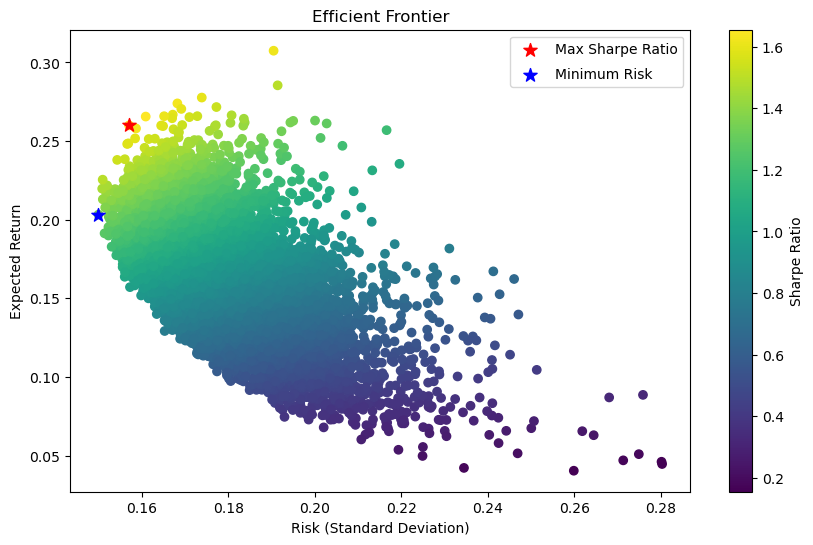

Max Sharpe Ratio Portfolio Weights: [0.15936533 0.45636802 0.00102282 0.23757832 0.06865852 0.06019726
 0.01680972]
Minimum Risk Portfolio Weights: [0.04662603 0.25815265 0.03387188 0.38832575 0.09202146 0.00058206
 0.18042018]
Maximum Return Portfolio Weights: [0.46855748183728974, 0.308456236230142, 0.004256677498803884, 0.07066262857453176, 0.05230212551549865, 0.01798104660565181, 0.07778380373808208]


In [196]:
# Step 1: Download data for selected assets
data = yf.download(optimal_stock_lst, start='2010-01-01', end='2016-12-31')['Adj Close']

# Step 2: Calculate expected returns and the covariance matrix
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Annualized mean return
cov_matrix = returns.cov() * 252  # Annualized covariance matrix

# Step 3: Define the number of portfolios and arrays to store results
num_portfolios = 10000
results = np.zeros((3, num_portfolios)) # 3D matrix

# Portfolio weights matrix
weights_record = []

for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(len(optimal_stock_lst))
    weights /= np.sum(weights)

    # Portfolio returns and risk (volatility)
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Store the results
    results[0, i] = portfolio_stddev
    results[1, i] = portfolio_return
    results[2, i] = results[1, i] / results[0, i]  # Sharpe Ratio
    weights_record.append(weights)

# Step 4: Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

# Highlight the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2, :])
plt.scatter(results[0, max_sharpe_idx], results[1, max_sharpe_idx], c='red', marker='*', s=100, label='Max Sharpe Ratio')

# Highlight the portfolio with the minimum risk
min_risk_idx = np.argmin(results[0, :])
plt.scatter(results[0, min_risk_idx], results[1, min_risk_idx], c='blue', marker='*', s=100, label='Minimum Risk')

plt.legend(labelspacing=0.8)
plt.title('Efficient Frontier')
plt.show()

max_sharpe_weights = weights_record[max_sharpe_idx]
min_risk_weights = weights_record[min_risk_idx]

max_sharpe_weights_list = max_sharpe_weights.tolist()
min_risk_weights_list = min_risk_weights.tolist()

print("Max Sharpe Ratio Portfolio Weights:", max_sharpe_weights)
print("Minimum Risk Portfolio Weights:", min_risk_weights)

# Find the index of the maximum return
max_return_idx = np.argmax(results[1, :])

# Get the weights corresponding to the maximum return
max_return_weights = weights_record[max_return_idx]
max_return_weights_list = max_return_weights.tolist()

# Print out the weights for the maximum return portfolio
print("Maximum Return Portfolio Weights:", max_return_weights_list)

{'DXCM': {'weight': 0.14285714285714285, 'return': 59.34994185354443, 'contribution': 8.478563121934918, 'contribution_pct': -78.29988128665703}, 'KHC': {'weight': 0.14285714285714285, 'return': -17.913134614269367, 'contribution': -2.5590192306099095, 'contribution_pct': 23.63264849071514}, 'KDP': {'weight': 0.14285714285714285, 'return': -23.657939883928957, 'contribution': -3.3797056977041366, 'contribution_pct': 31.21172197556042}, 'MNST': {'weight': 0.14285714285714285, 'return': -18.547863776703466, 'contribution': -2.649694825243352, 'contribution_pct': 24.470041359446334}, 'CPRT': {'weight': 0.14285714285714285, 'return': -37.398874949559335, 'contribution': -5.342696421365619, 'contribution_pct': 49.34002254005822}, 'CHTR': {'weight': 0.14285714285714285, 'return': -2.703771152356149, 'contribution': -0.38625302176516413, 'contribution_pct': 3.567062639727441}, 'ORLY': {'weight': 0.14285714285714285, 'return': -34.92661014107357, 'contribution': -4.989515734439081, 'contributi

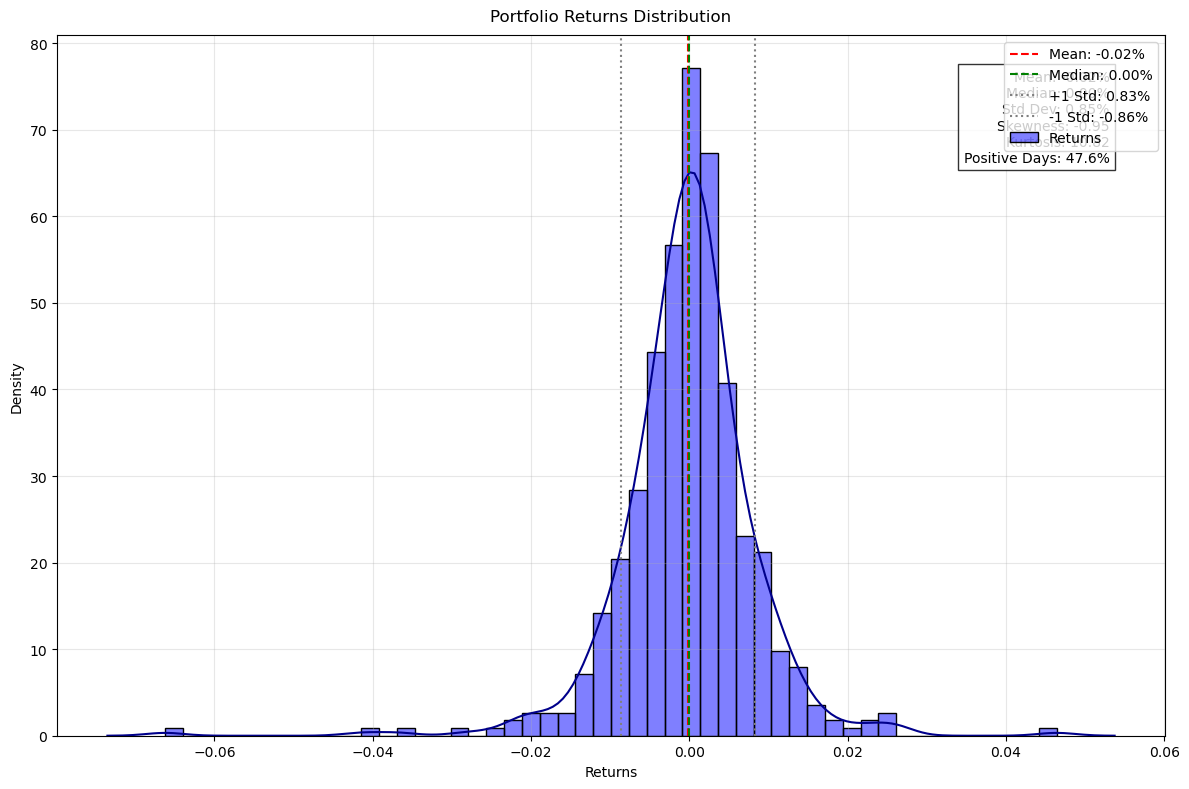

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


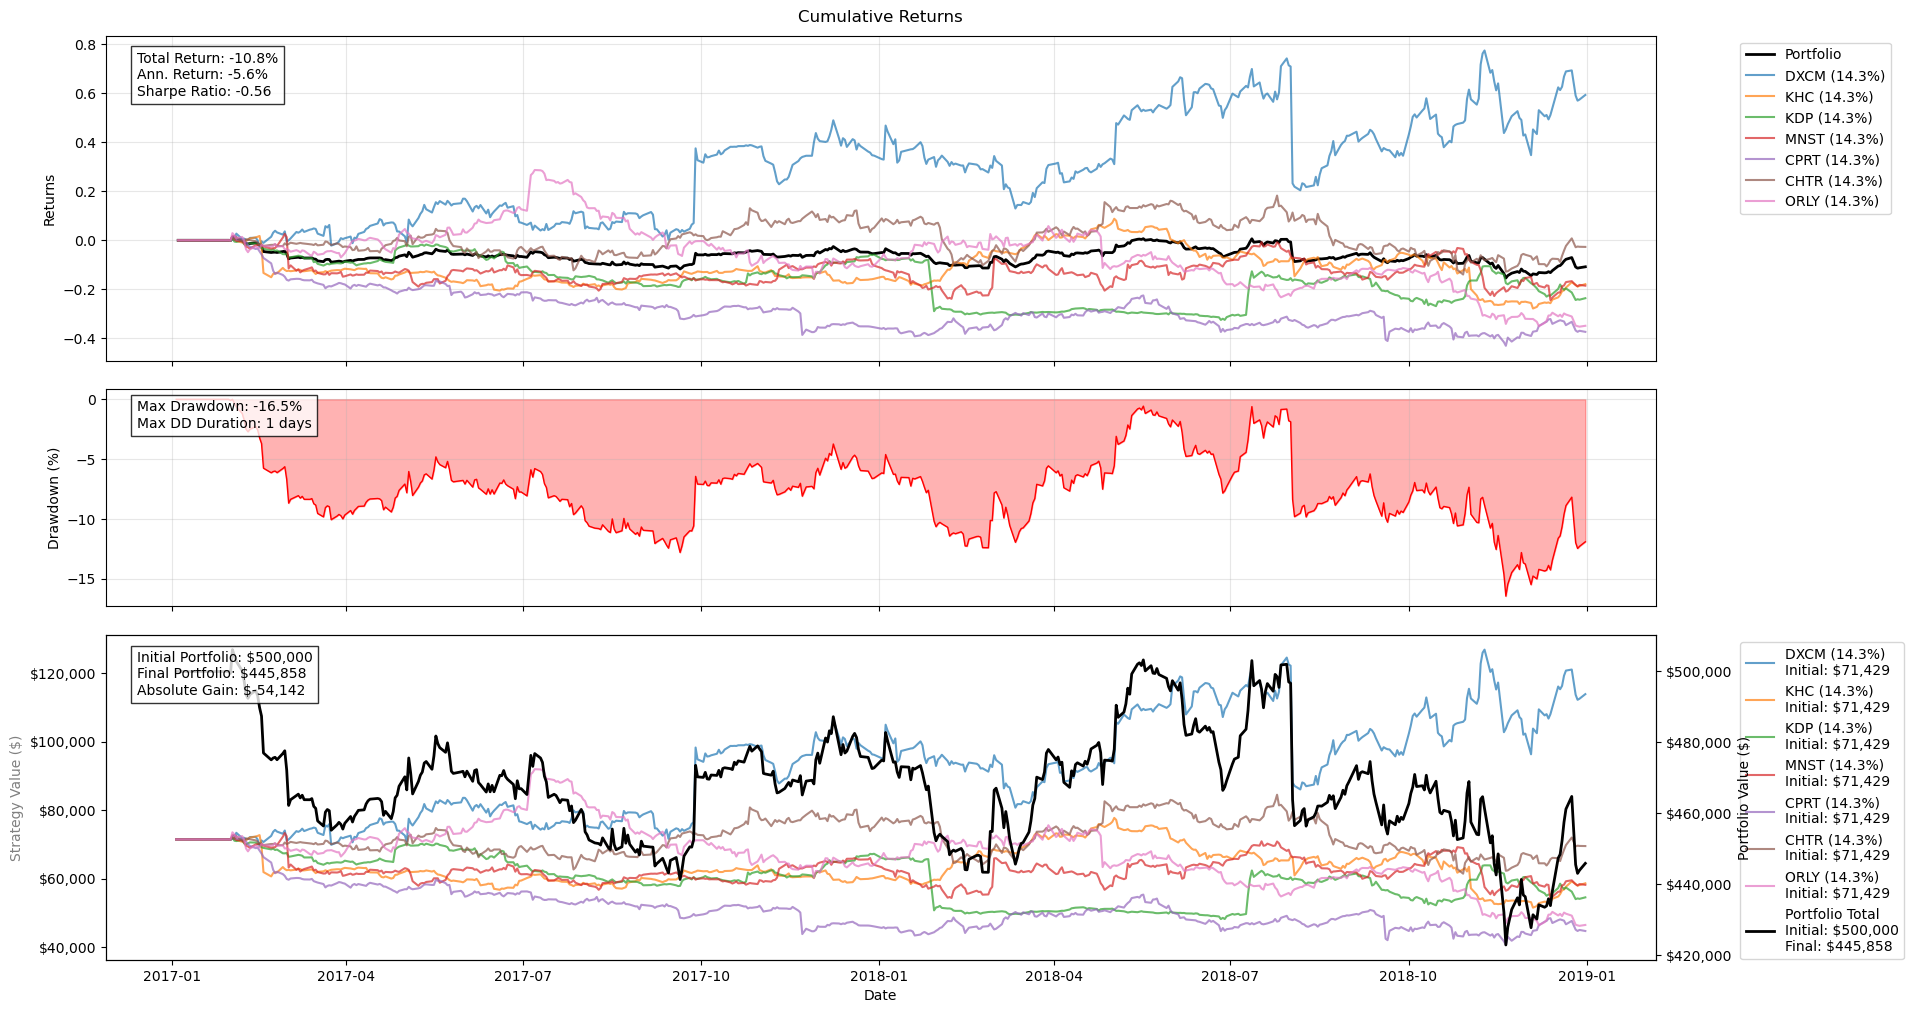

0           NaN
1      0.005706
2     -0.000771
3      0.003511
4     -0.003555
         ...   
497   -0.027487
498    0.048403
499    0.008526
500   -0.001242
501         NaN
Name: benchmark_log_returns, Length: 502, dtype: float64
0      2257.830078
1      2270.750000
2      2269.000000
3      2276.979980
4      2268.899902
          ...     
497    2351.100098
498    2467.699951
499    2488.830078
500    2485.739990
501            NaN
Name: benchmark_close, Length: 502, dtype: float64


/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:745: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


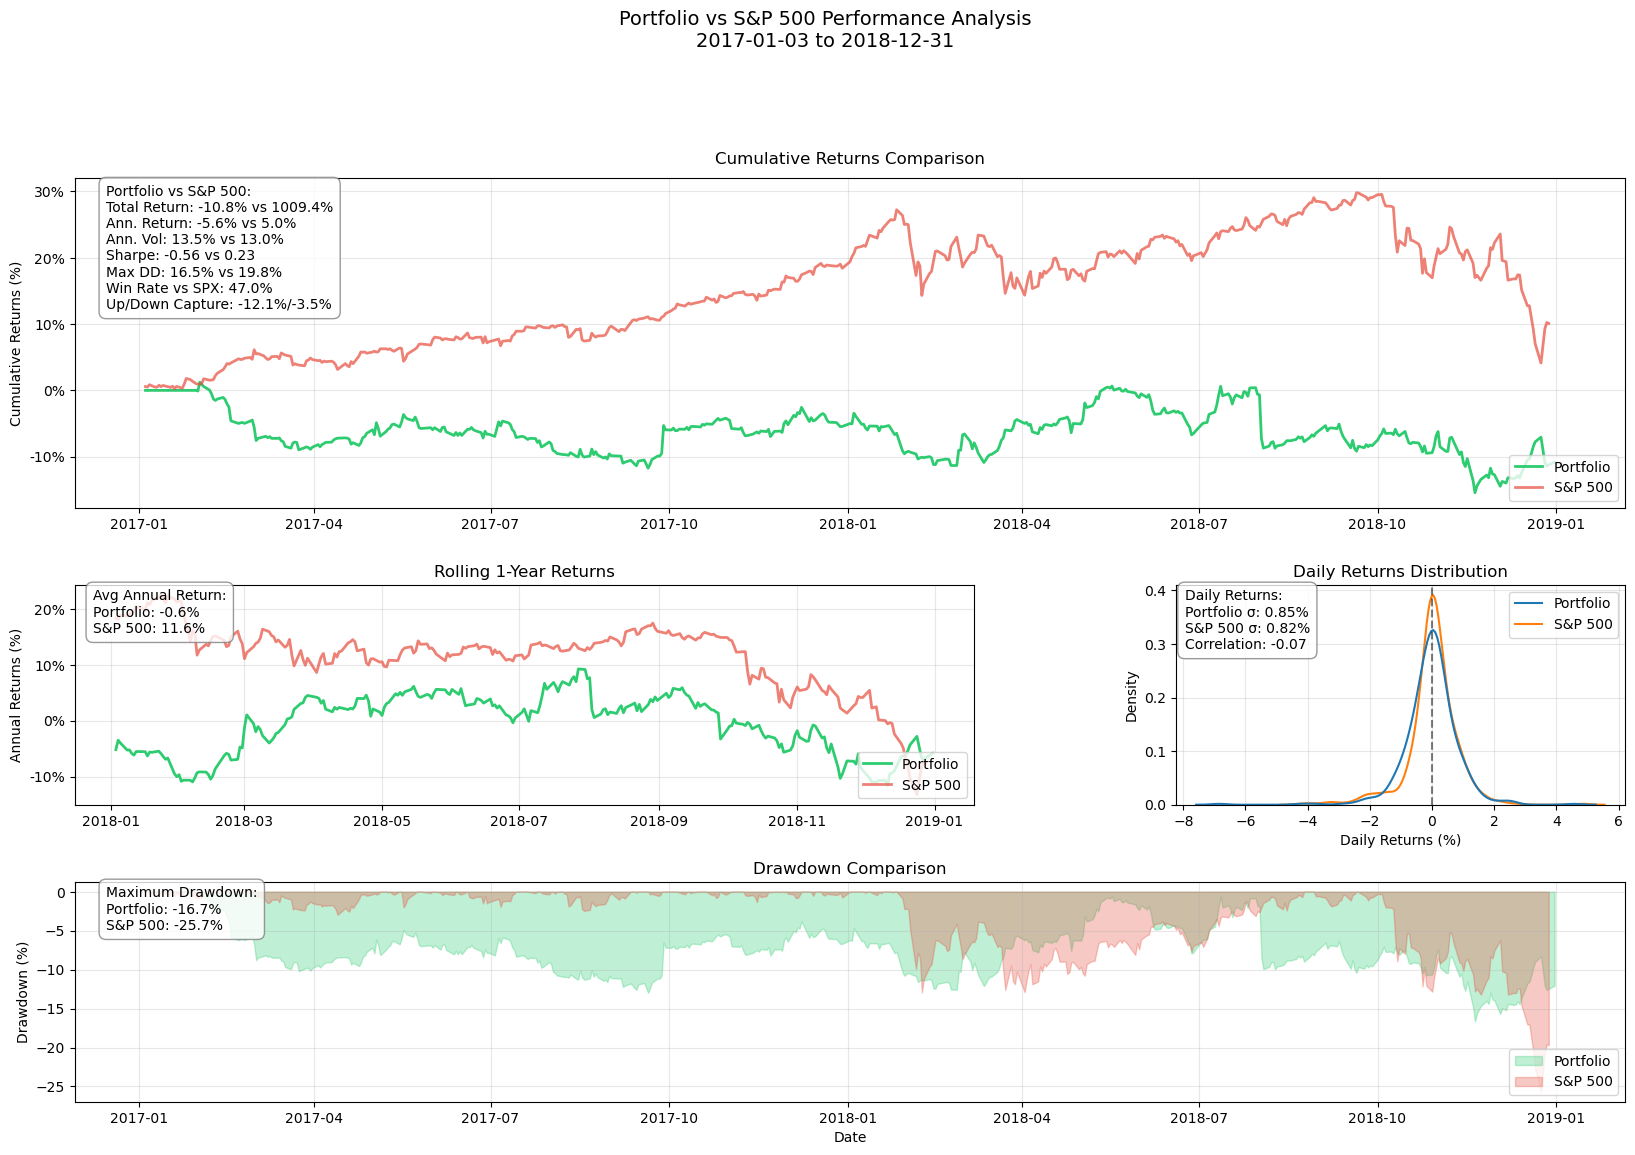

In [197]:
# equal weighted portfolio results
optimal_list_eventbasedbacktesters = []

test_start = '2017-01-01'
test_end = '2019-01-01'
interval = '1d'

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval="1d",
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    # WeightedMCRSIStrategy_test.run_strategy()
    optimal_list_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)
    # WeightedMCRSIStrategy_test.plot_strategy_performance()

# Create portfolio manager which will allocate capital
portfolio_manager = EventBasedPortfolioManager(
    strategies=optimal_list_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=None  # Equal weights
)

# Run portfolio analysis
portfolio_manager.run_portfolio()
portfolio_manager.calculate_portfolio_performance()
portfolio_manager.print_benchmark_comparison()

# Plot results
portfolio_manager.plot_portfolio_returns()
portfolio_manager.plot_portfolio_performance()
# Plot comparison
portfolio_manager.plot_benchmark_comparison()
# # Plot results
# portfolio_manager.plot_portfolio_returns()
# portfolio_manager.plot_portfolio_performance()
# # Plot comparison
# portfolio_manager.plot_benchmark_comparison()

{'DXCM': {'weight': 0.1593653332651939, 'return': 59.34095707038971, 'contribution': 9.45689139979822, 'contribution_pct': -146.41405936001567}, 'KHC': {'weight': 0.45636801930199583, 'return': -17.920595049052658, 'contribution': -8.178386467249315, 'contribution_pct': 126.61991251274594}, 'KDP': {'weight': 0.001022820881040171, 'return': -23.383623855482583, 'contribution': -0.023917258753776656, 'contribution_pct': 0.37029323853491936}, 'MNST': {'weight': 0.23757832489439856, 'return': -18.546144589455203, 'contribution': -4.40616196481208, 'contribution_pct': 68.21734882982838}, 'CPRT': {'weight': 0.06865851535462181, 'return': -37.399334080851546, 'contribution': -2.5677827532427764, 'contribution_pct': 39.75508235876898}, 'CHTR': {'weight': 0.06019726222044005, 'return': -2.6573970627072563, 'contribution': -0.15996802780761588, 'contribution_pct': 2.4766667321175593}, 'ORLY': {'weight': 0.01680972408230984, 'return': -34.48479670879271, 'contribution': -0.5796799177093519, 'cont

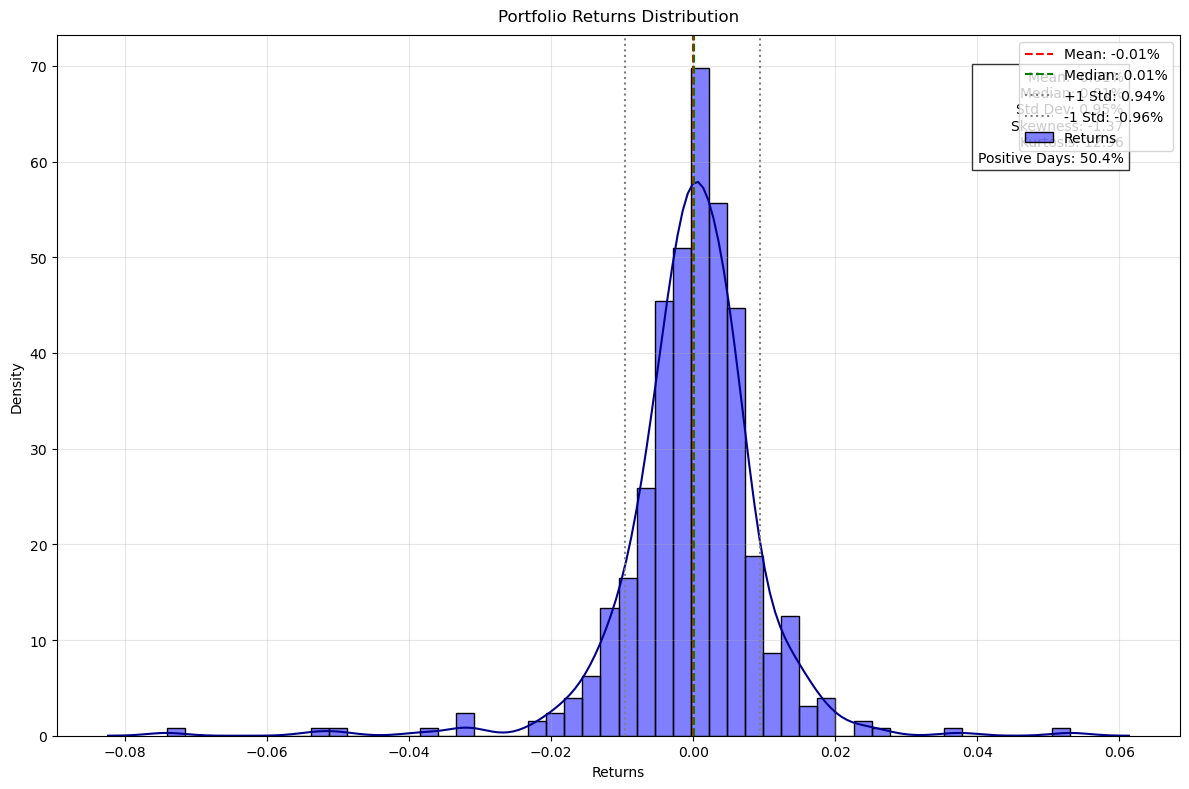

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


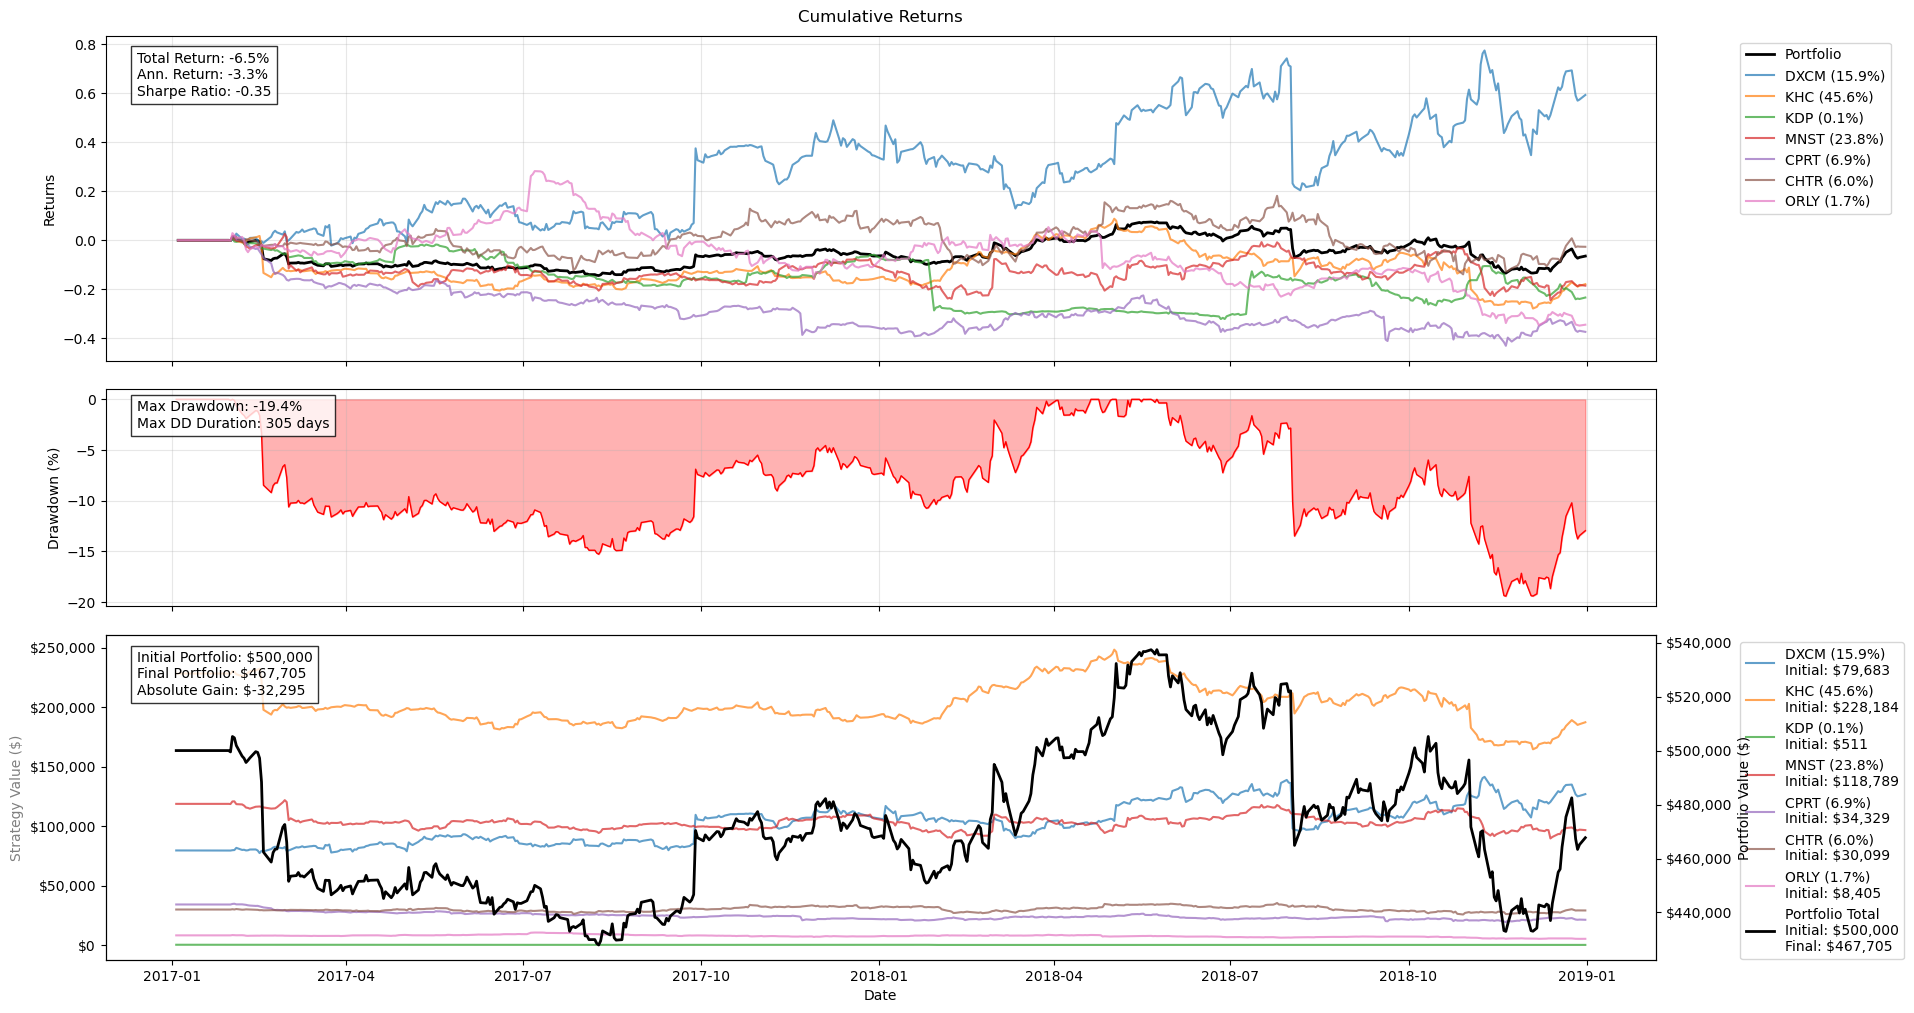

0           NaN
1      0.005706
2     -0.000771
3      0.003511
4     -0.003555
         ...   
497   -0.027487
498    0.048403
499    0.008526
500   -0.001242
501         NaN
Name: benchmark_log_returns, Length: 502, dtype: float64
0      2257.830078
1      2270.750000
2      2269.000000
3      2276.979980
4      2268.899902
          ...     
497    2351.100098
498    2467.699951
499    2488.830078
500    2485.739990
501            NaN
Name: benchmark_close, Length: 502, dtype: float64


/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:745: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


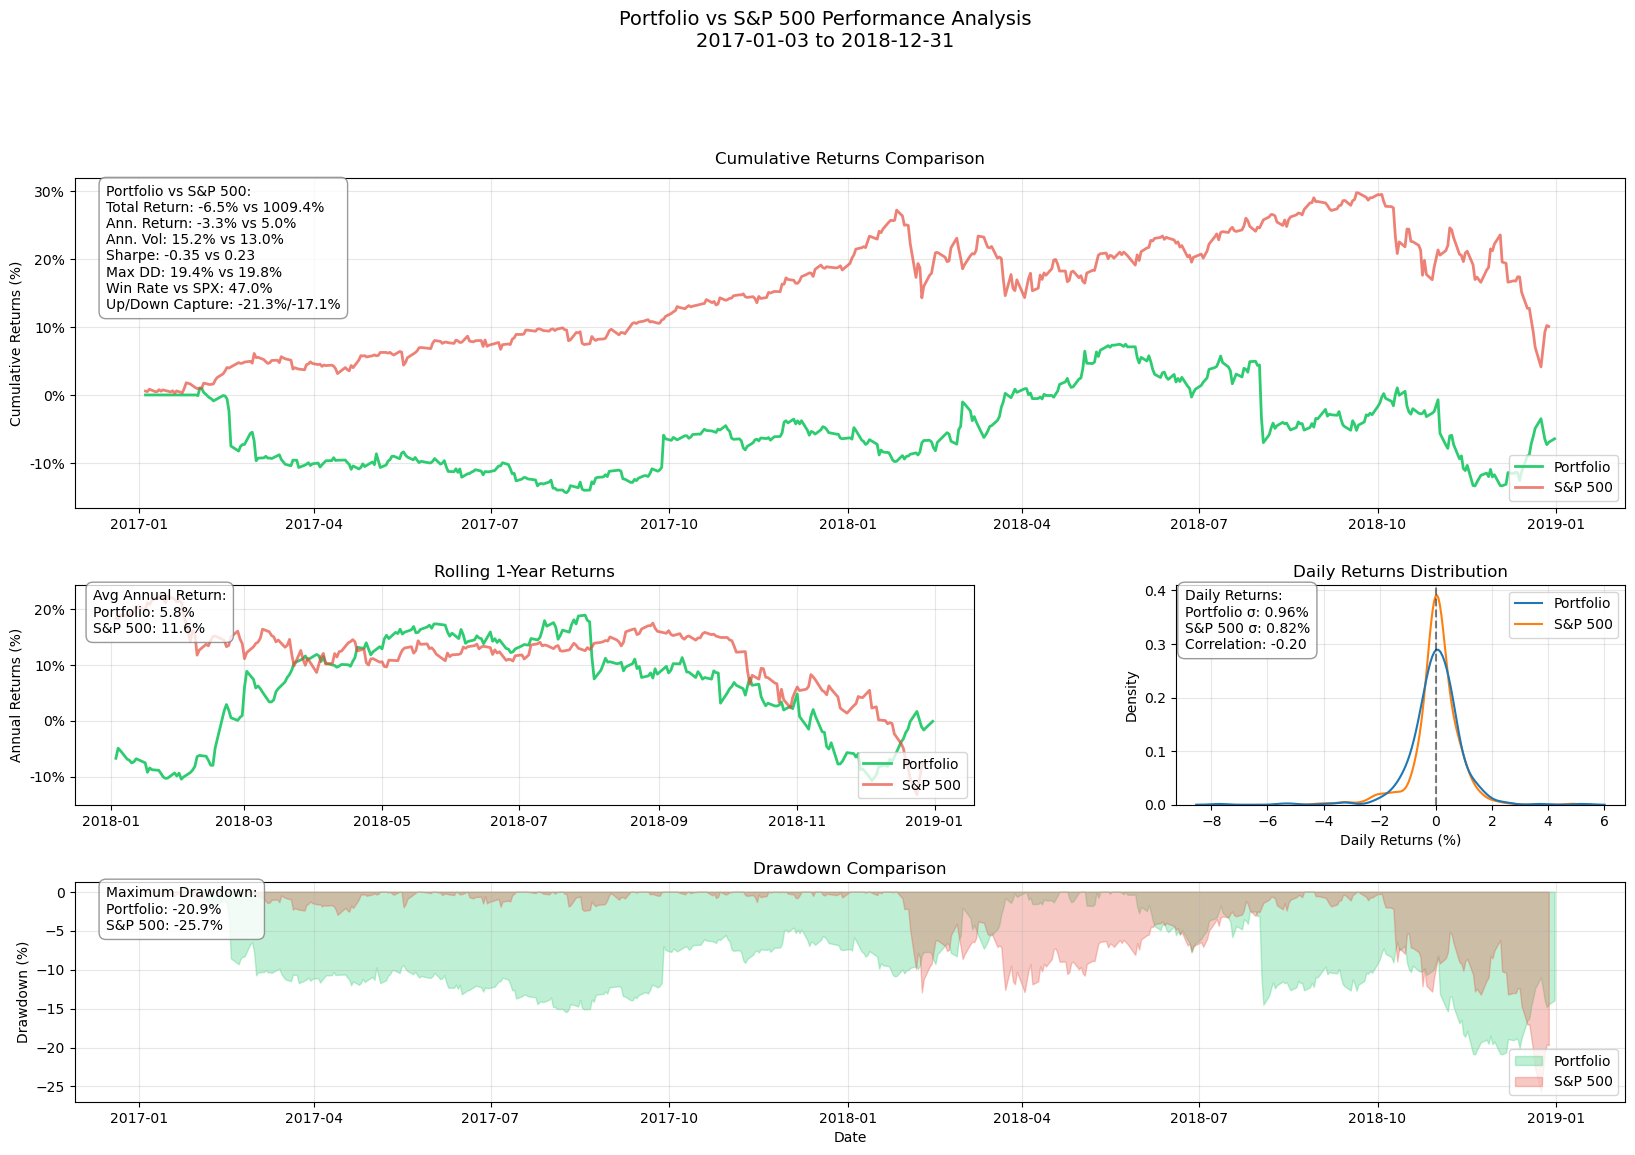

In [198]:
# Max Sharpe Ratio Portfolio Weights
optimal_list_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval="1d",
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    # WeightedMCRSIStrategy_test.run_strategy()
    optimal_list_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)
    # WeightedMCRSIStrategy_test.plot_strategy_performance()

# Create portfolio manager which will allocate capital
portfolio_manager = EventBasedPortfolioManager(
    strategies=optimal_list_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=max_sharpe_weights_list  # Equal weights
)

# Run portfolio analysis
portfolio_manager.run_portfolio()
portfolio_manager.calculate_portfolio_performance()
portfolio_manager.print_benchmark_comparison()
# Plot results
portfolio_manager.plot_portfolio_returns()
portfolio_manager.plot_portfolio_performance()
# Plot comparison
portfolio_manager.plot_benchmark_comparison()

{'DXCM': {'weight': 0.046626027926181826, 'return': 59.34900602961628, 'contribution': 2.767208412528022, 'contribution_pct': -14.11027282755397}, 'KHC': {'weight': 0.25815264528499976, 'return': -17.924685703850574, 'contribution': -4.627305030351244, 'contribution_pct': 23.595091767923634}, 'KDP': {'weight': 0.033871875907553174, 'return': -23.64603268485077, 'contribution': -0.8009354848072117, 'contribution_pct': 4.084050249606749}, 'MNST': {'weight': 0.3883257499092249, 'return': -18.54593276371903, 'contribution': -7.201863248237257, 'contribution_pct': 36.72302195934897}, 'CPRT': {'weight': 0.0920214625387278, 'return': -37.395534300946935, 'contribution': -3.4411917587902985, 'contribution_pct': 17.546981408639997}, 'CHTR': {'weight': 0.000582058773412809, 'return': -12.552901137754501, 'contribution': -0.00730652623901364, 'contribution_pct': 0.03725670903117069}, 'ORLY': {'weight': 0.18042017965989976, 'return': -34.91798844244158, 'contribution': -6.299909748147614, 'contrib

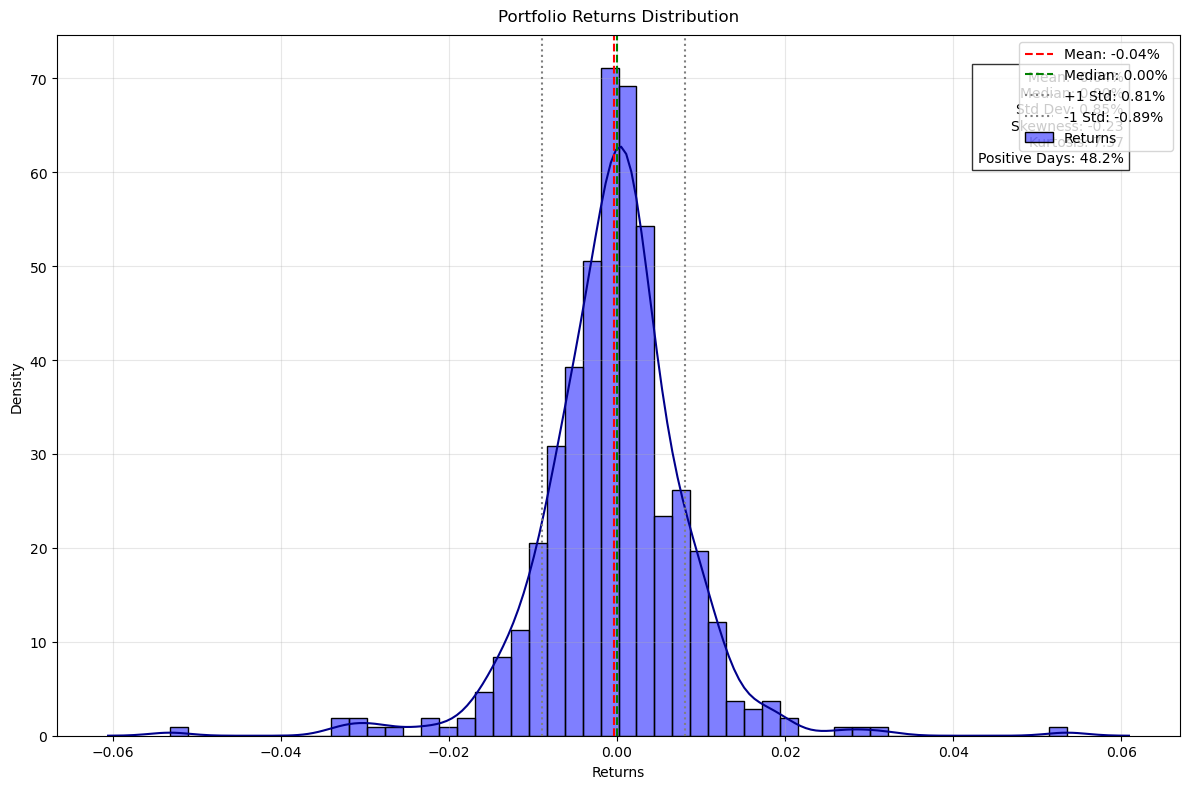

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


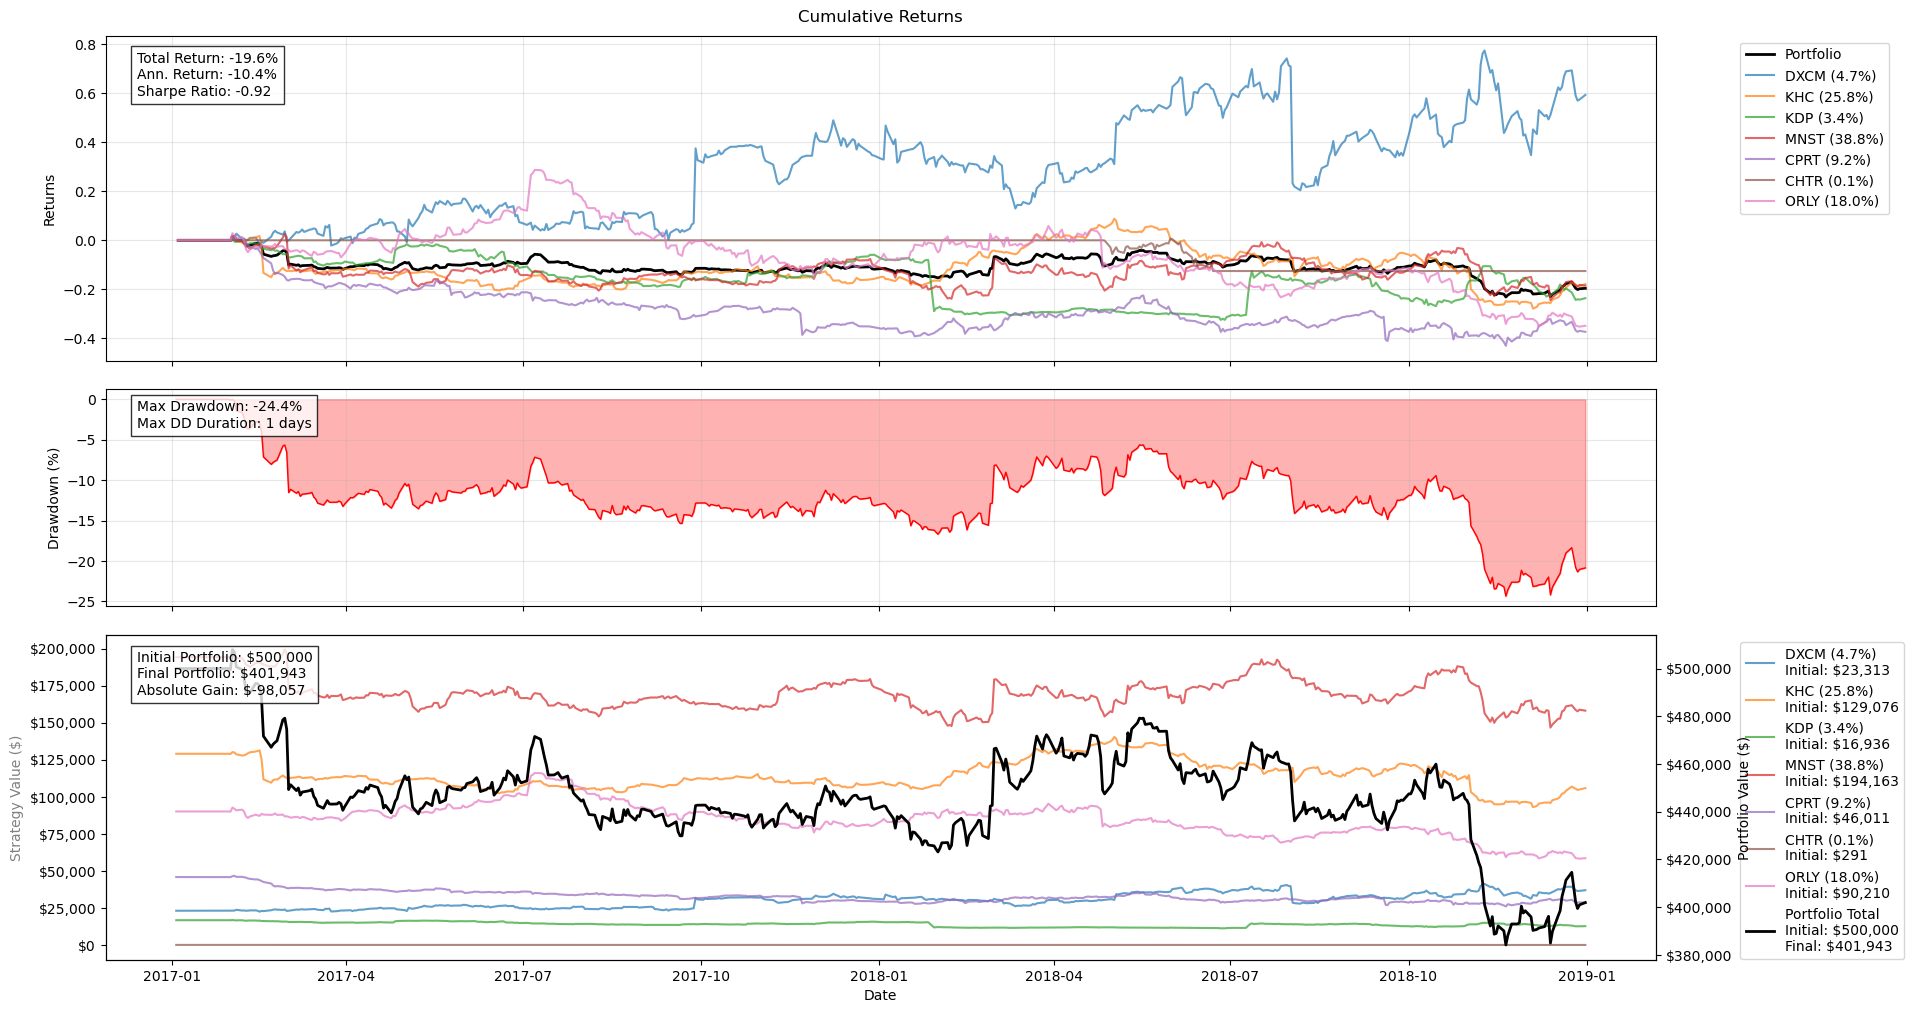

0           NaN
1      0.005706
2     -0.000771
3      0.003511
4     -0.003555
         ...   
497   -0.027487
498    0.048403
499    0.008526
500   -0.001242
501         NaN
Name: benchmark_log_returns, Length: 502, dtype: float64
0      2257.830078
1      2270.750000
2      2269.000000
3      2276.979980
4      2268.899902
          ...     
497    2351.100098
498    2467.699951
499    2488.830078
500    2485.739990
501            NaN
Name: benchmark_close, Length: 502, dtype: float64


/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:745: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


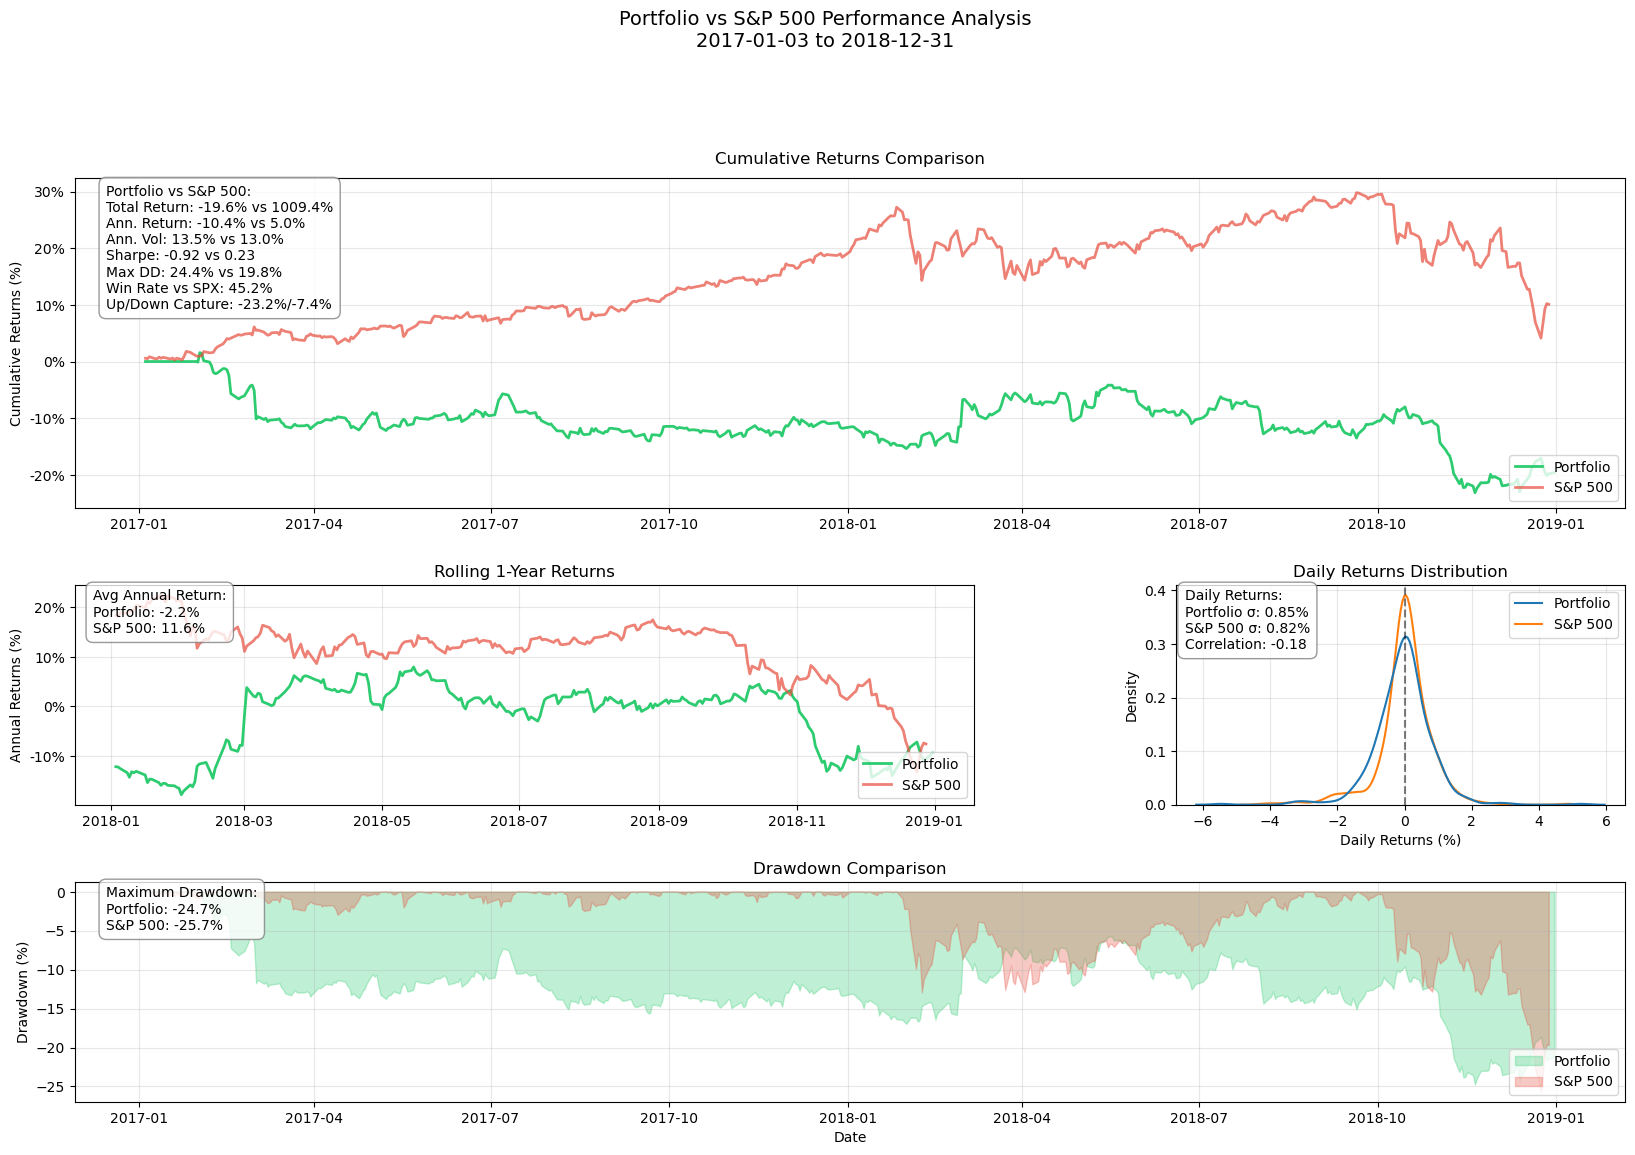


Portfolio vs S&P 500 Comparison (2017-01-03 to 2018-12-31)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                   -19.61%       10.09%      -29.71%     -294.28%
Annual Return                  -10.40%        4.97%      -15.36%     -309.39%
Annual Volatility               13.55%       12.99%        0.56%        4.29%
Sharpe Ratio                    -0.92        0.23       -1.14     -500.83%
Sortino Ratio                   -0.84        0.20       -1.04     -512.74%
Max Drawdown                    24.36%       19.78%        4.58%       23.15%
Win Rate                        48.30%       54.60%       -6.30%      -11.53%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: -0.18
Tracking Error: 20.35%
Information Ratio: -0.76

Market Capture Metrics:
---------------------

In [199]:
# Minimum Risk Portfolio Weights

optimal_list_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval="1d",
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    # WeightedMCRSIStrategy_test.run_strategy()
    optimal_list_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)
    # WeightedMCRSIStrategy_test.plot_strategy_performance()

# Create portfolio manager which will allocate capital
portfolio_manager = EventBasedPortfolioManager(
    strategies=optimal_list_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=min_risk_weights_list  # minimum risk weights
)

# Run portfolio analysis
portfolio_manager.run_portfolio()
# Plot results
portfolio_manager.plot_portfolio_returns()
portfolio_manager.plot_portfolio_performance()
# Plot comparison
portfolio_manager.plot_benchmark_comparison()

# Print detailed statistics
portfolio_manager.print_benchmark_comparison()

{'DXCM': {'weight': 0.46855748183728974, 'return': 59.352540373296556, 'contribution': 27.810076857957906, 'contribution_pct': 172.14748510019606}, 'KHC': {'weight': 0.308456236230142, 'return': -17.92510275680931, 'contribution': -5.529109730403942, 'contribution_pct': -34.225807422020694}, 'KDP': {'weight': 0.004256677498803884, 'return': -23.728549268277042, 'contribution': -0.10100478174953426, 'contribution_pct': -0.6252308920282964}, 'MNST': {'weight': 0.07066262857453176, 'return': -18.536383160508763, 'contribution': -1.3098295583862358, 'contribution_pct': -8.107991413967211}, 'CPRT': {'weight': 0.05230212551549865, 'return': -37.40562052367705, 'contribution': -1.9563934596144694, 'contribution_pct': -12.11029425266512}, 'CHTR': {'weight': 0.01798104660565181, 'return': -2.936760813129591, 'contribution': -0.05280603305053508, 'contribution_pct': -0.3268752486444929}, 'ORLY': {'weight': 0.07778380373808208, 'return': -34.79048474043267, 'contribution': -2.706136237002554, 'co

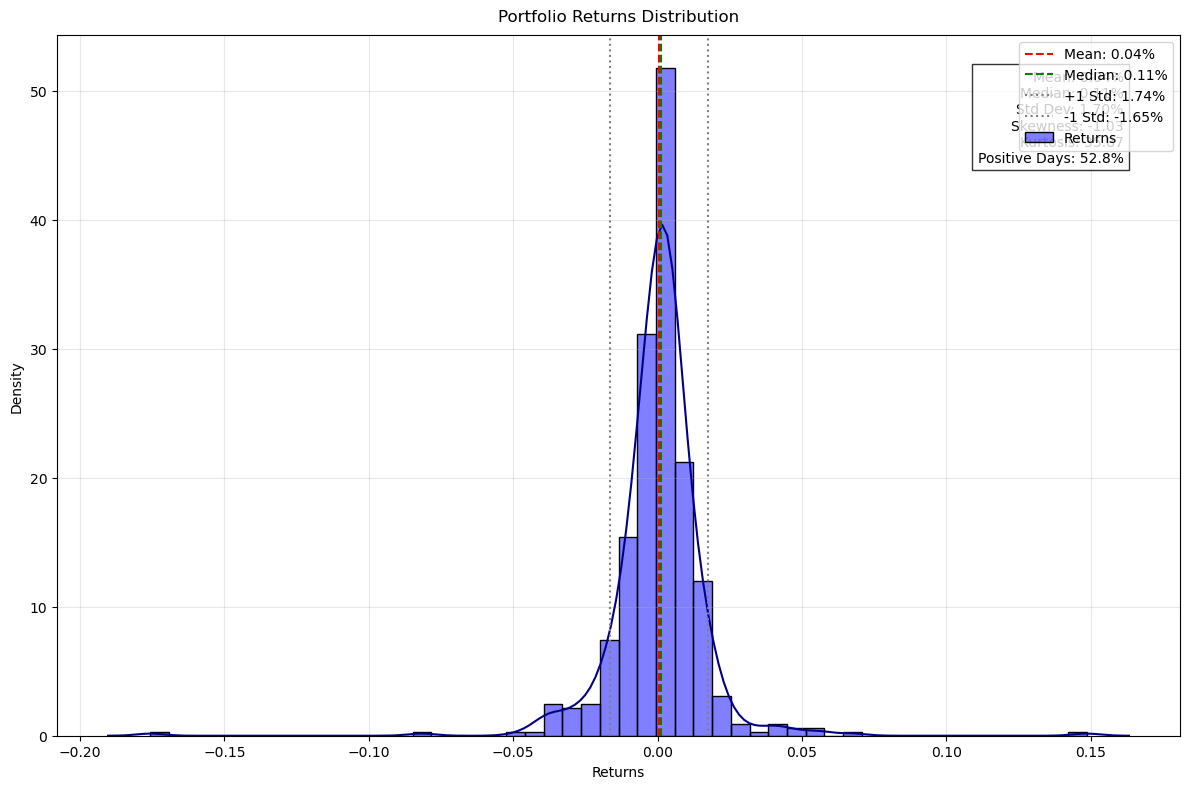

/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:526: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


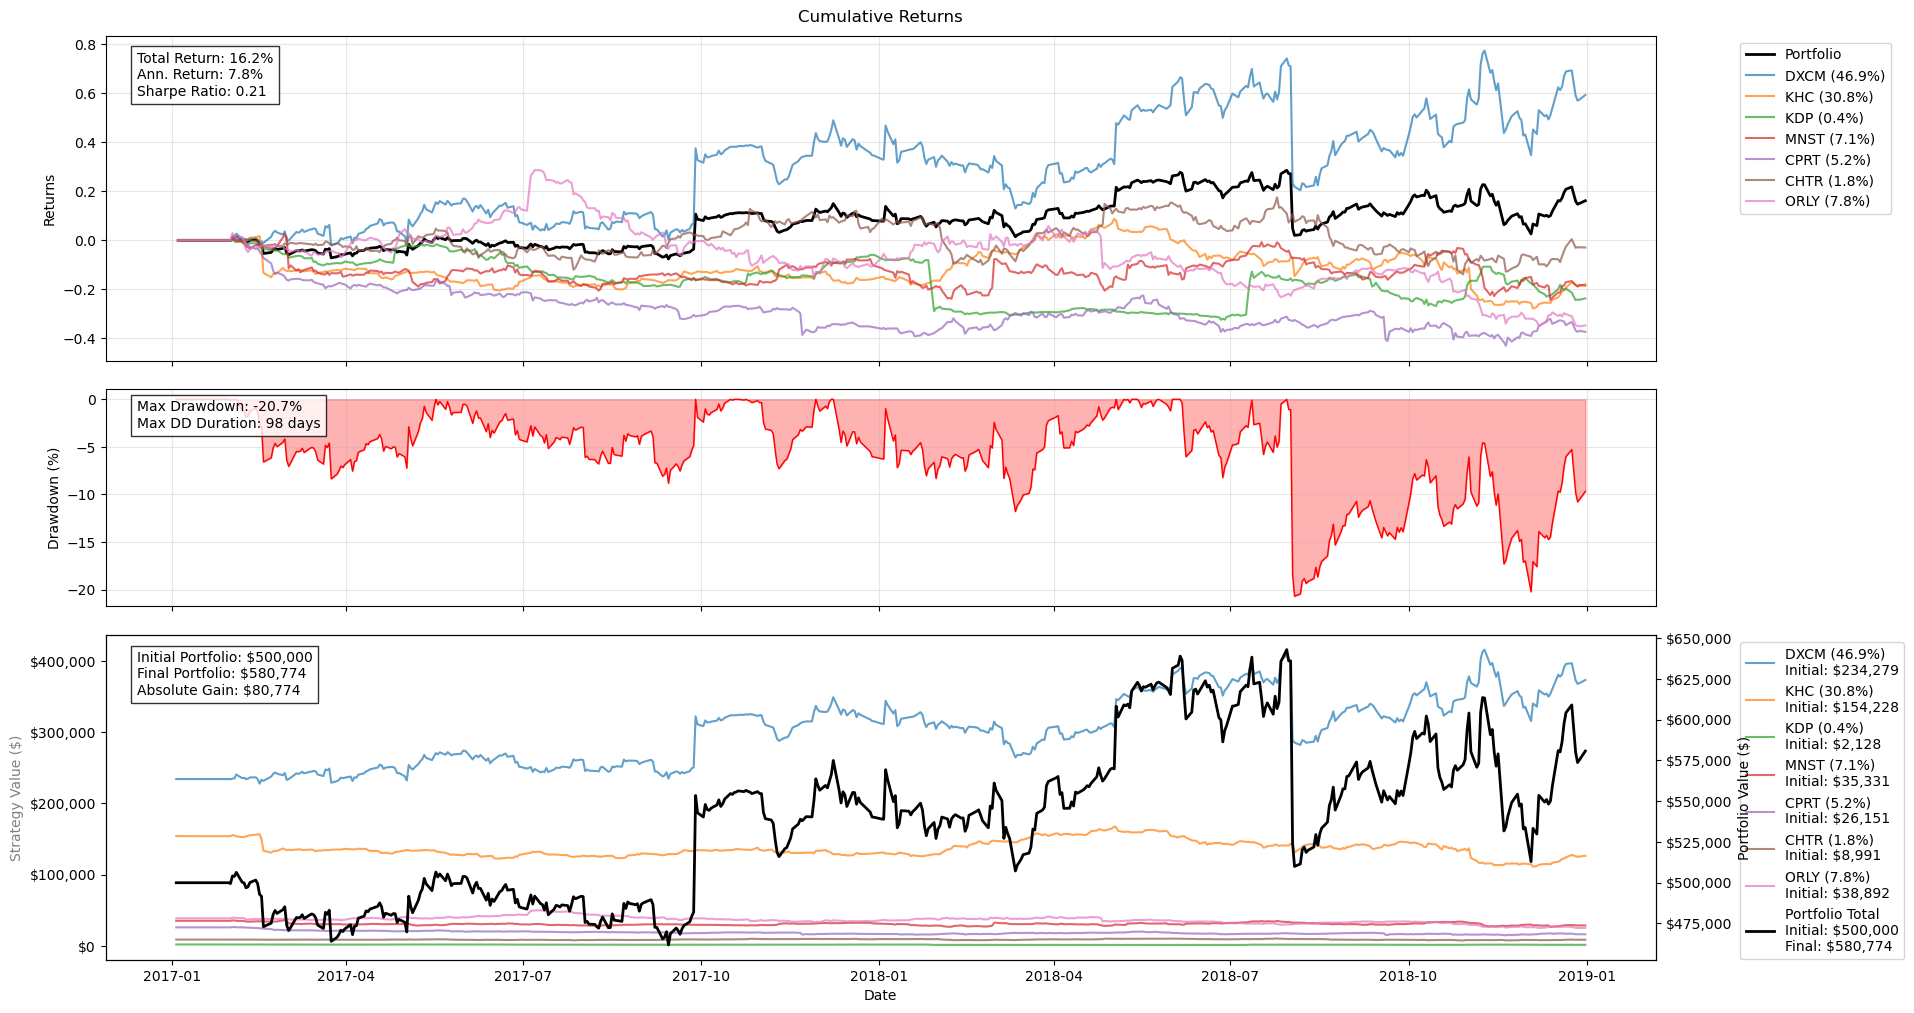

0           NaN
1      0.005706
2     -0.000771
3      0.003511
4     -0.003555
         ...   
497   -0.027487
498    0.048403
499    0.008526
500   -0.001242
501         NaN
Name: benchmark_log_returns, Length: 502, dtype: float64
0      2257.830078
1      2270.750000
2      2269.000000
3      2276.979980
4      2268.899902
          ...     
497    2351.100098
498    2467.699951
499    2488.830078
500    2485.739990
501            NaN
Name: benchmark_close, Length: 502, dtype: float64


/var/folders/w3/p_0x2kls1sb4qpyv2ch25z6c0000gn/T/ipykernel_34887/631695353.py:745: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


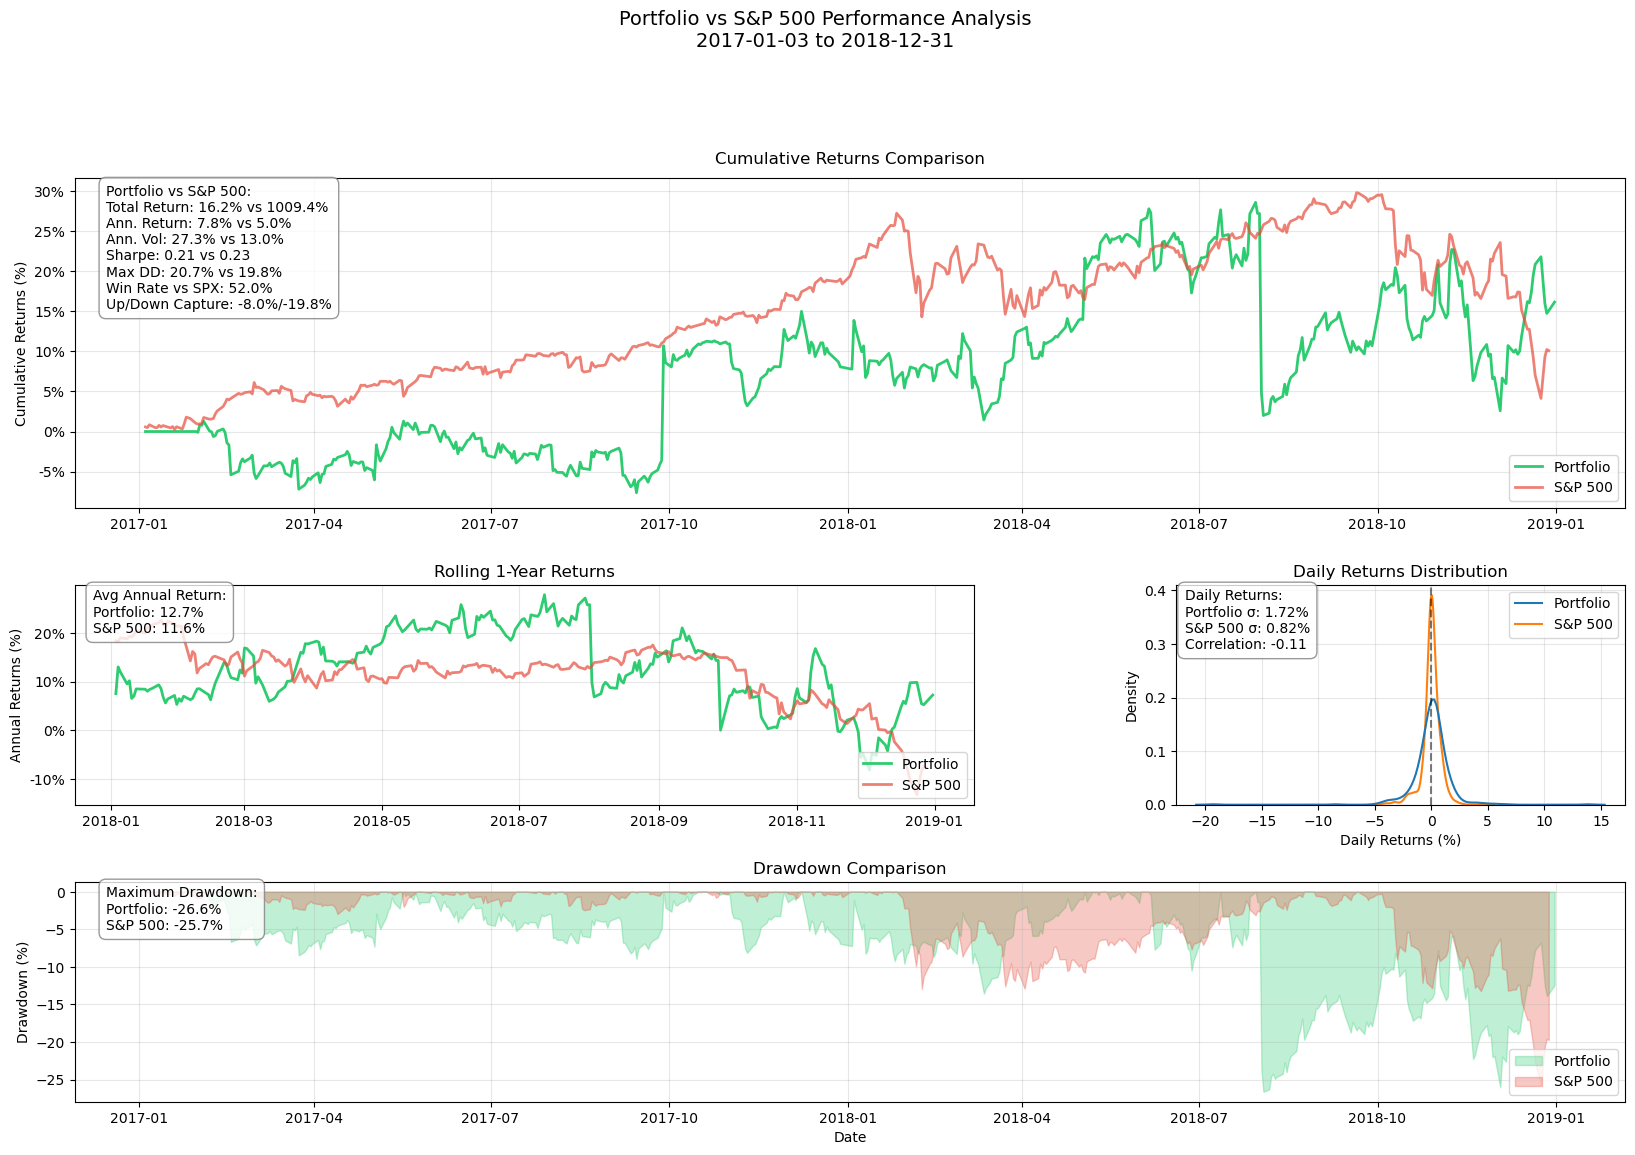


Portfolio vs S&P 500 Comparison (2017-01-03 to 2018-12-31)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                    16.15%       10.09%        6.06%       60.04%
Annual Return                    7.82%        4.97%        2.86%       57.54%
Annual Volatility               27.28%       12.99%       14.28%      109.95%
Sharpe Ratio                     0.21        0.23       -0.01       -6.49%
Sortino Ratio                    0.19        0.20       -0.02       -8.73%
Max Drawdown                    20.69%       19.78%        0.91%        4.59%
Win Rate                        52.89%       54.60%       -1.71%       -3.12%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: -0.11
Tracking Error: 31.41%
Information Ratio: 0.09

Market Capture Metrics:
----------------------

In [200]:
# Max Returns Weights

optimal_list_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval="1d",
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    # WeightedMCRSIStrategy_test.run_strategy()
    optimal_list_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)
    # WeightedMCRSIStrategy_test.plot_strategy_performance()

# Create portfolio manager which will allocate capital
portfolio_manager = EventBasedPortfolioManager(
    strategies=optimal_list_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=max_return_weights_list  # minimum risk weights
)

# Run portfolio analysis
portfolio_manager.run_portfolio()
# Plot results
portfolio_manager.plot_portfolio_returns()
portfolio_manager.plot_portfolio_performance()
# Plot comparison
portfolio_manager.plot_benchmark_comparison()

# Print detailed statistics
portfolio_manager.print_benchmark_comparison()